_"Данные важнее алгоритмов". (Народная мудрость)_

In [1]:
import pandas as pd
import numpy as np
import collections
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.stats import f_oneway, ttest_ind
import scipy
#------------------------------------------------------------------------------#
data = pd.read_csv('stud_math.csv')
# Общая информация:
display(data.head())
display(data.info())
# Итак, 395 записей, 30 колонок. Колонки: 13 числовых и 17 типа object.

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

None

#### Пользовательские функции и установки.

In [2]:
#------------------------------------------------------------------------------#
# Изменение установок по умолчанию для графиков:
def set_rc_params():
    plt.rcParams.update({
        "axes.facecolor"       : "LightYellow",
        "axes.labelsize"       : 14,
        "axes.titlesize"       : 16,
        "axes.grid"            : True,
        "axes.grid.axis"       : "both",
        "grid.linestyle"       : "dotted",
        "grid.alpha"           : 0.75,
        "legend.facecolor"     : "Lavender",
        "legend.shadow"        : True,
        "legend.fontsize"      : 12,
        "legend.edgecolor"     : "black",
        "legend.title_fontsize": 11,
        "figure.facecolor"     : "Lavender",
        "xtick.labelsize"      : 12,
        "ytick.labelsize"      : 12,
        "font.size"            : 16
    })

# Восстановление установок графиков по умолчанию:
def set_rc_default():
    plt.rcdefaults()


# Переопределяем графические настройки:
set_rc_params()
##matplotlib.rcParams.keys()
#------------------------------------------------------------------------------#
# Функция обработки нулевых баллов:
def dist_0(df):
    """
    Равномерно заполняет константами соответствующие интервалы оценок за
    госэкзамен:
        - интервал от 1 до 9 баллов: 5 баллов
        - интервал от 10 до 19 баллов: 15 баллов
    На входе:
        - исходный датафрейм с нулевыми баллами в столбце "score"
    На выходе:
        - датафрейм с ненулевыми баллами в полуинтервале оценок (0, 19]
    """
    cnt = 1
    for ind in df[df.score == 0].index:
        if cnt <= 18:
            df.loc[ind, 'score'] = 5
        else:
            df.loc[ind, 'score'] = 15
        cnt += 1
    return df

#------------------------------------------------------------------------------#
# Функция для осуществления теста Стьюдента:
def get_stud_test(df, col):
    """
    Тест Стьюдента для фактора с несколькими категориями.
    На входе:
        - рабочий датафрейм: df
        - название признака (столбца), который играет роль фактора: col
    На выходе:
        - сообщение о наличии или отсутствии статистически значимых различий
    """
    idx_cat = df[col].value_counts().index
    combo_lst = list(combinations(idx_cat, 2))
    for cat in combo_lst:
        df0 = df.loc[df.loc[:, col] == cat[0], "score"]
        df1 = df.loc[df.loc[:, col] == cat[1], "score"]
        p_val = ttest_ind(df0, df1).pvalue
        if p_val <= 0.05 / len(combo_lst):
            print("Найдены статистически значимые различия для колонки", col)
    else: print(f"Не найдено статистически значимых различий для \"{col}\".")


#### Целевой объект score содержит 6 пропусков данных. Удалим эти записи.

In [3]:
#------------------------------------------------------------------------------#
data = data.dropna(subset=['score'], axis = 0)
# Проверяем:
display(data.isnull().sum())
# Пропуски в score устранены. Делаем бэк-ап текущего датафрейма:
data2 = data.copy()

school                  0
sex                     0
age                     0
address                15
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 38
paid                   39
activities             14
nursery                15
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime                9
goout                   7
health                 15
absences               11
score                   0
dtype: int64

### 1. Обзор данных. Щупаем, визуально осматриваем, проверяем на наличие статистически значимых различий...

#### 1.0. Целевой признак score.

Коэффициент асимметрии "score" с "нулями": -0.737
Без "нулей": 0.19

Нулевой балл у 37 учеников из 389 (9.5 %).
Минимальный ненулевой балл: 20.0.

Среднее баллов: - с учётом нуля: 52.3; - без учёта: 57.8.


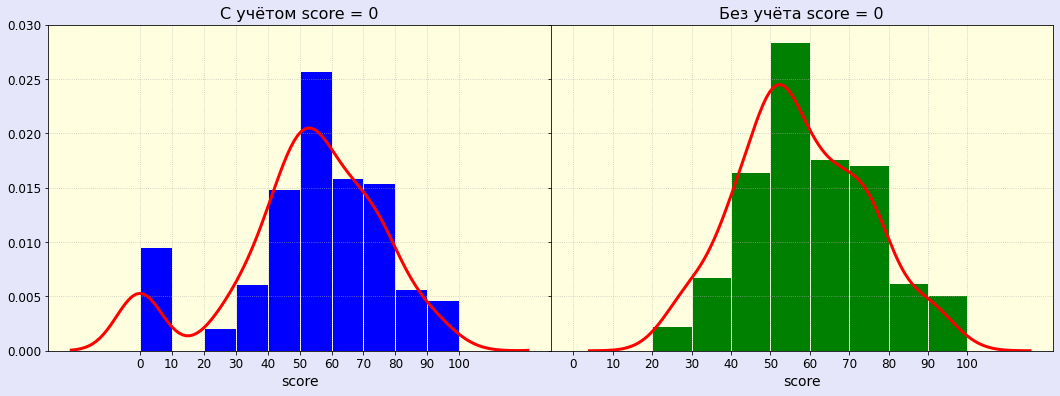

In [4]:
#------------------------------------------------------------------------------#
# Рассмотрим распределение score:
df = data2.copy()
# Коэффициент асимметрии:
# - с учётом выбросов в нуле:
As_0 = df.score.skew()
# - без учёта выбросов в нуле:
As = df.query("score > 0").score.skew()
print('Коэффициент асимметрии "score" с "нулями":', As_0.round(3))
print('Без "нулей":', As.round(3))
#--
num_0 = df.query("score == 0").score.count(); num_tot = df.shape[0]
num_0_r = (num_0/num_tot * 100).round(1)
min_ne_0 = df[df.score > 0].score.min()
print(f'\nНулевой балл у {num_0} учеников из {num_tot} ({num_0_r} %).')
print(f'Минимальный ненулевой балл: {min_ne_0}.')
#--
mean_0 = round(df.score.mean(), 1)
mean_ = round(df[df.score>0].score.mean(), 1)
print(f'\nСреднее баллов: - с учётом нуля: {mean_0}; - без учёта: {mean_}.')
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
#------------------------------------------------------------------------------#
h1 = {'color': 'b', 'ec': 'lightyellow', 'alpha': 1, 'align': 'mid'};
k1 = {'color': 'r', 'lw': 3}
bins = [k for k in range(0, 110, 10)]
sns.distplot(df.score, hist_kws=h1, kde_kws=k1, ax=ax[0], bins=bins)
#------------------------------------------------------------------------------#
h2 = {'color': 'g', 'ec': 'lightyellow', 'alpha': 1, 'align': 'mid'};
k2 = {'color': 'r', 'lw': 3}
sns.distplot(df[df.score > 0].score, hist_kws=h2, kde_kws=k2, ax=ax[1],
             bins=bins);
#------------------------------------------------------------------------------#
fig.subplots_adjust(wspace=0.)
[axs.set_xticks(range(0, 110, 10)) for axs in ax]
[axs.set_ylim(0, 0.03) for axs in ax]
# Поясняющий текст:
ax[0].set_title("С учётом score = 0")
ax[1].set_title("Без учёта score = 0");

#### 1.0.1. Промежуточные выводы.
    1. Наблюдаются "выбросы" в нуле: 9.5% учащихся получили нулевой балл в качестве оценки.
    2. Если учитывать эти нулевые оценки, то кривая плотности будет смещена влево - коэффициент асимметрии отрицательный.
    3. Без учёта нулевых оценок - кривая плотности имеет более длинный правый хвост, т.е. средний балл возрастает.
---
#### 1.0.2. Обработка выбросов в нуле.
###### Пояснение.
Около 10% именно нулевых баллов за госэкзамен по математике - это фантастический нонсенс. Неявка ученика на госэкзамен не является  
причиной простановки нулевого балла: в этом случае ставится отметка о неявке, и экзамен для этого ученика переносится на другую дату.  
Да и чисто психологически понятно: это итоговый госэкзамен, важнейшее мероприятие, и неявка на него возможна лишь в случае форс-мажорных  
обстоятельств. Нормальный ребёнок в 15 лет (минимальный возраст в данных) уже хорошо понимает это. Вряд ли форс-мажор составил 10%  
случаев - это уже не форс-мажор.  
Каждый итоговый бюллетень сканируется и далее обрабатывается компьютером на основе алгоритма распознавания текста. В реальности нулевой  
балл возможен лишь в двух **_редких_** случаях:
    1. Когда все ответы неправильны или когда бланк заполнен абсолютно неправильно.
    2. Сдан "пустой" бланк, т.е. в соответствующих местах бланка отсутствуют ответы на задания.
Подобные случаи возможны, но они очень редкие - тем более, что результаты компьютерной проверки всегда валидируются экспертом-человеком.  
Кроме того, хотя бы несколько баллов всегда можно получить (несколько правильных ответов), даже если "ставить галочки" наобум, случайно.
###### Наиболее вероятная причина наличия нулевого балла.
Выше мы увидели, что минимальный ненулевой балл начинается с 20. Отсюда следует наиболее вероятная причина появления нулевых баллов  
в исходном наборе данных - ученик на госэкзамене набрал **_меньше 20 баллов_**. Иначе говоря, оценка в 20 баллов является "пороговой",  
минимально допустимой - либо для перехода на новый год обучения, либо для выдачи аттестата об образовании (а не справки о том, что  
ученик "прослушал курс").  
Что касается российских реалий - доля "двоечников" по математике (считается сложным предметом - профильным) в 10% является вполне реалистичной.
###### Обработка нулевых баллов.
Учитывая вышесказанное, распределим 37 учеников с нулевыми баллами в диапазоне от 1-го до 19-ти баллов. Это можно сделать несколькими  
способами, например:
    1. C помощью генератора случайных целых чисел в указанном диапазоне.
    2. Равномерно распределить 37 нулевых баллов в этом диапазоне (18 от 1 до 9, 19 от 10 до 19).
    3. Использовать стандартное нормальное распределение (диапазон 100 баллов на 6 сигм).
Однако как бы мы ни обработали этот выброс в нуле баллов, он всё равно будет вносить искажения. Например, в форму функции плотности  
распределения. Цель проекта - "на ранней стадии выявлять студентов, находящихся в группе риска", и "двоечники" являются  
целевой группой. Точнее говоря, для них риск уже осуществился. Учитывая цель проекта, нельзя просто выбросить эти данные.  
Снизим "остроту" выброса в нуле, воспользовавшись вторым способом из указанных выше - см. пользовательскую функцию dist_0.

Было:
	Коэффициент асимметрии "score" с "нулями": -0.737
	Среднее баллов: 52.3
Стало:
	Коэффициент асимметрии "score" с "нулями": -0.431
	Среднее баллов: 53.2


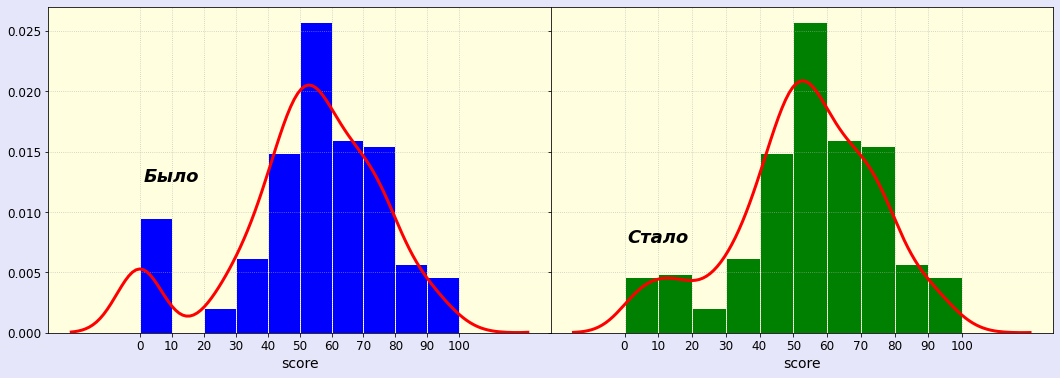

In [5]:
#------------------------------------------------------------------------------#
cols = ["score"]; df = data2[cols].copy()
# Применяем пользовательскую функцию dist_0 для обработки нулевых баллов:
df = dist_0(df)
As_avant, mean_avant = data2.score.skew(), data2.score.mean()
As_apres, mean_apres = df.score.skew(), df.score.mean()
print('Было:\n\tКоэффициент асимметрии "score" с "нулями":', As_avant.round(3))
print('\tСреднее баллов:', round(mean_avant, 1))
print('Стало:\n\tКоэффициент асимметрии "score" с "нулями":', As_apres.round(3))
print('\tСреднее баллов:', round(mean_apres, 1))
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
[axs.set_xticks(range(0, 110, 10)) for axs in ax]; fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
h1 = {'color': 'b', 'ec': 'lightyellow', 'alpha': 1, 'align': 'mid'}
k1 = {'color': 'r', 'lw': 3}
bins = [k for k in range(0, 110, 10)]
sns.distplot(data.score, hist_kws=h1, kde_kws=k1, bins=bins, ax=ax[0])
#------------------------------------------------------------------------------#
h2 = {'color': 'g', 'ec': 'lightyellow', 'alpha': 1, 'align': 'mid'}
k2 = {'color': 'r', 'lw': 3}
sns.distplot(df.score, hist_kws=h2, kde_kws=k2, bins=bins, ax=ax[1])
#------------------------------------------------------------------------------#
ax[0].text(10, 0.0125, "Было", fontsize=18, style="italic", weight="bold",
           ha="center")
ax[1].text(10, 0.0075, "Стало", fontsize=18, style="italic", weight="bold",
          ha="center");

#### 1.1. Столбец school.
Пропусков нет.

,Всего учеников,Всего двоечников,в %,Средний балл
school,,,,
GP,344,33,9.6,53.5
MS,45,4,8.9,50.8


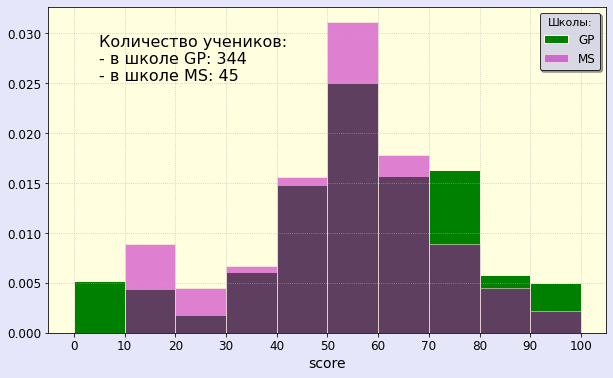

In [6]:
df = data2.copy()
df = dist_0(df)
# Признак "school" - категориальная переменная номинального типа.
# Нечисловой признак.
na_data_nominal = ["school"]
#------------------------------------------------------------------------------#
# Итак, две школы: GP и MS. Пропусков нет. В школе GP учатся существенно
# больше учеников. Сравним успеваемость учеников этих двух школ:
df_gr = df.groupby("school")[["age"]].count()
df_gr = df_gr.join(df[df.score < 20].groupby("school")[["sex"]].count())
df_gr["в %"] = round(df_gr.sex * 100 / df_gr.age , 1)
df_gr_mean = df.groupby("school")[["score"]].apply(lambda x: round(x.mean(), 1))
df_gr = df_gr.join(df_gr_mean)
df_gr.columns = ["Всего учеников", "Всего двоечников", "в %", "Средний балл"]
display(df_gr)
#------------------------------------------------------------------------------#
df_GP = df[df.school=='GP']
df_MS = df[df.school=='MS']
fig, ax = plt.subplots(figsize=(10, 6)); ax.set_xticks(range(0, 110, 10))
#------------------------------------------------------------------------------#
h1 = {'color': 'g', 'alpha': 1, 'ec': 'lightyellow', 'align': 'mid'}
h2 = {'color': 'm', 'alpha': 0.5, 'ec': 'lightyellow', 'align': 'mid'}
bins = [k for k in range(0, 110, 10)]
# Школа GP:
sns.distplot(df_GP.score, hist_kws=h1, kde=False, bins=bins, norm_hist=True,
             label='GP')
# Школа MS:
sns.distplot(df_MS.score, hist_kws=h2, kde=False, bins=bins, norm_hist=True,
             label = 'MS')
# Легенда:
ax.legend(title='Школы:')
# Дополнительный текст:
ax.text(5, 0.0277, "Количество учеников:\n- в школе GP: 344\n- в школе MS: 45",
        va="center_baseline");

#### 1.1. Столбец school. Выводы.
Итак, мы видим, что в базе данных представлена информация о двух школах. Одна школа называется GP, вторая - MS.  
В школе GP учится 344 ученика, а в школе MS - существенно меньше: 45 учеников.  
График выше можно интерпретировать следующим образом:
* в обеих школах наблюдается заметное количество учеников с нулевым баллом за сдачу госэкзамена:  
33 (9.6%) человека - в школе GP, 4 (8.9%) - в школе MS. Грубо говоря, каждый десятый ученик не достигает порога в 20 баллов.
* успеваемость в школе MS несколько ниже, чем в школе GP: средний балл в GP составляет 53.5, в MS - 50.8.
* в школе GP заметно смещение в область более высоких оценок: например, количество учеников с баллами от 70 до 80  
даже несколько превышает количество учеников с баллами от 60 до 70.

Проверим, насколько статистически значимо различие в успеваемости учеников двух школ. $\downarrow$

In [7]:
#------------------------------------------------------------------------------#
cols = ['school', 'score']; df = data2[cols].copy(); df = dist_0(df)
df_GP = df[df.school == "GP"]
df_MS = df[df.school == "MS"]
print('One-Way ANOVA p-value =', f_oneway(df_GP.score, df_MS.score).pvalue.round(3))
print('Student\'s test p-value =', ttest_ind(df_GP.score, df_MS.score).pvalue.round(3))

One-Way ANOVA p-value = 0.403
Student's test p-value = 0.403


Таким образом, двойная проверка на значимость показывает, что школы GP и MS статистически неразличимы: $p_{value} > \alpha = 0.05$.  
Занесём признак "school" в список на удаление. $\downarrow$

In [8]:
features_to_delete = ["school"]
features_to_delete

['school']

#### 1.2. Пол (sex) и возраст (age).
Пропуски отсутствуют.

In [9]:
# Признак "sex" является категориальным признаком номинального типа.
# Нечисловой признак.
na_data_nominal.append("sex")
na_data_nominal

['school', 'sex']

age         15   16  17  18  19  20  21  22  All
school sex                                      
GP     F    38   53  50  27  11   0   0   0  179
       M    44   50  36  28   5   1   0   1  165
MS     F     0    0   8  14   2   1   0   0   25
       M     0    0   4  11   3   1   1   0   20
All         82  103  98  80  21   3   1   1  389

Средний возраст учеников:
	- в школе GP: 16.5 лет
	- в школе MS: 18.0 лет


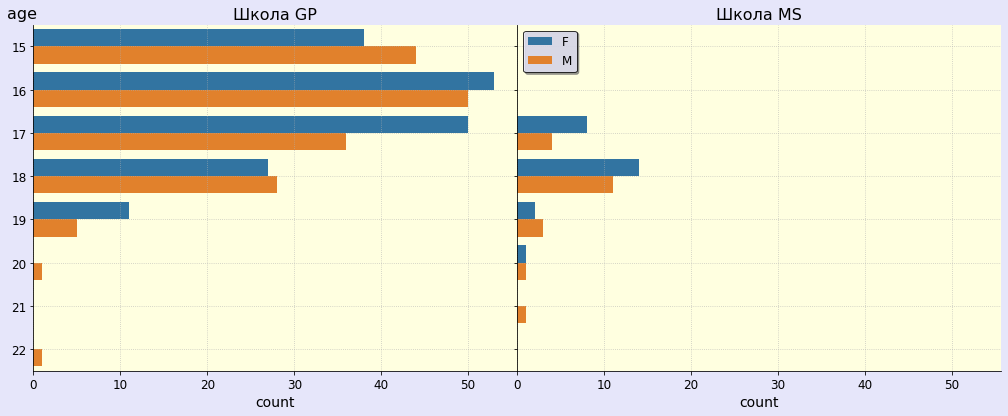

In [10]:
#------------------------------------------------------------------------------#
col = ['school', 'sex', 'age', 'score']; df = data2[col].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
# Распределение учеников по полу и возрасту в двух школах:
df_gr = df.pivot_table(index='age', columns=['school','sex'], values='score',
                       aggfunc='count', fill_value=0, margins=True)
display(df_gr.T)
age_mean_GP = df[df.school == 'GP'].age.mean()
age_mean_MS = df[df.school == 'MS'].age.mean()
print('Средний возраст учеников:')
print(f'\t- в школе GP: {age_mean_GP} лет\n\t- в школе MS: {age_mean_MS} лет')
#------------------------------------------------------------------------------#
sns.catplot(kind='count', y='age', hue='sex', col='school', data=df,
            legend=False)
#------------------------------------------------------------------------------#
fig = plt.gcf(); ax = fig.get_axes(); fig.set_size_inches(15, 6)
fig.subplots_adjust(wspace=0.0); ax[1].legend(loc = 'upper left')
ax[0].set_title("Школа GP"); ax[1].set_title("Школа MS")
[axs.grid("both") for axs in ax]
ax[0].set_ylabel("age", rotation=0, position=(0, 1.01), ha="left", fontsize=16);
#------------------------------------------------------------------------------#

school GP_median       MS_median       GP_count     MS_count    
sex            F     M         F     M        F   M        F   M
age                                                             
15          55.0  67.5         0   0.0       34  42        0   0
16          55.0  60.0         0   0.0       50  46        0   0
17          57.5  50.0        55  60.0       46  33        7   4
18          55.0  52.5        50  50.0       21  24       13  11
19          55.0  57.5        45  42.5        9   4        1   2
20           0.0  90.0        75  45.0        0   1        1   1
21           0.0   0.0         0  35.0        0   0        0   1
22           0.0  40.0         0   0.0        0   1        0   0

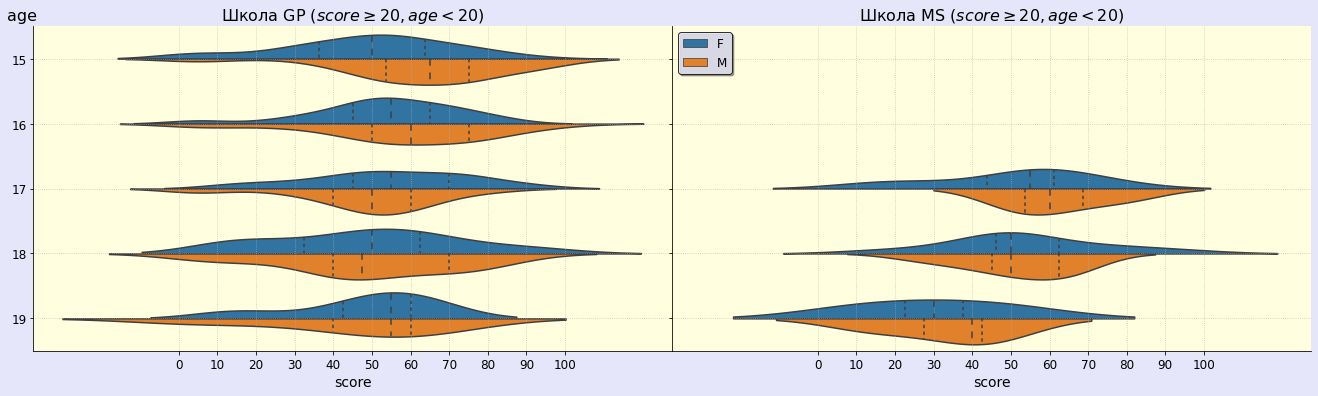

In [11]:
#------------------------------------------------------------------------------#
col = ['school', 'sex', 'age', 'score']; df = data2[col].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
# Посмотрим, как влияют на успеваемость пол и возраст
# (без редких данных и выбросов в нуле: age < 20 & score > 0):
sns.catplot(x='score', y='age', hue='sex', col='school',
            data=df.query('age<20 & score>0'), kind='violin', inner='quartile',
            split=True, legend=False, orient='h')
#------------------------------------------------------------------------------#
fig = plt.gcf(); ax = fig.get_axes(); fig.subplots_adjust(wspace=0.0)
fig.set_size_inches(20, 6); ax[1].legend(loc = 'upper left')
ax[0].set_title("Школа GP ($score \geq 20, age < 20$)")
ax[1].set_title("Школа MS ($score \geq 20, age < 20$)")
[axs.grid("both") for axs in ax]
ax[0].set_ylabel("age", rotation=0, position=(0, 1.01), ha="left", fontsize=16)
[axs.set_xticks(range(0, 110, 10)) for axs in ax];
#------------------------------------------------------------------------------#
# Медианный балл, возраст и пол в двух школах (без учёта двоечников):
df_pvt = df[df.score >= 20].pivot_table(index="age", columns=["school", "sex"],
                                values="score", aggfunc="median", fill_value=0)
df_pvt1 = df[df.score >= 20].pivot_table(index="age", columns=["school", "sex"],
                                values="score", aggfunc="count", fill_value=0)
display(df_pvt.join(df_pvt1, lsuffix="_median", rsuffix="_count").round(1))

#### 1.2. Пол (sex) и возраст (age). Выводы.
В обеих школах девочек больше, чем мальчиков. В школе GP средний возраст учеников (16.5 лет) заметно меньше среднего возраста  
уащихся в школе MS (18 лет). Графики выше можно интерпретировать следующим образом:
* у мальчиков наблюдается тенденция к снижению успеваемости с возрастом.
* в школе GP успеваемость мальчиков в 15 и 16 лет существенно выше, чем у девочек того же возраста.
* ситуация в этой школе меняется на противоположную в 17 и 18, но выравнивается к 19 годам.
* в школе MS успеваемость мальчиков 17 лет выше, чем у девочек того же возраста, а в 18 лет - примерно одинаковая.

Проверим, насколько статистически значимо различие в успеваемости учеников в зависимости от пола и от возраста.  
Строго говоря, нужно провести _**двухфакторный**_ дисперсионный анализ, но мы сделаем проще:  
    1. Сначала проверим на значимость только пол.
    2. Добавим к полу отдельные уровни возраста (15 лет и т.д.), и если хотя бы для одного уровня возраста обнаружатся
    значимые различия, оставляем оба признака "sex" и "age".
$\downarrow$

In [12]:
#------------------------------------------------------------------------------#
cols = ['sex', 'score', 'age']; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df_male = df[df.sex == "M"]
df_female = df[df.sex == "F"]
print('Only "sex": One-Way ANOVA p-value =', f_oneway(df_male.score,
                                            df_female.score).pvalue.round(3))
#------------------------------------------------------------------------------#
# Первый уровень возраста - 15 лет:
df_male_15 = df[(df.sex == "M")&(df.age == 15)]
df_female_15 = df[(df.sex == "F")&(df.age == 15)]
print('Features "sex" & "age" 15 yo: One-Way ANOVA p-value =',
      f_oneway(df_male_15.score, df_female_15.score).pvalue.round(3))

Only "sex": One-Way ANOVA p-value = 0.066
Features "sex" & "age" 15 yo: One-Way ANOVA p-value = 0.001


Таким образом, пол (sex) и возраст (age) оставляем для модели: у детей в возрасте 15 лет успеваемость значимо  
различается в зависимости от пола: $p_{value} < \alpha = 0.05$.

#### 1.3. address — тип адреса ученика ('U' - городской, 'R' - за городом).
Есть пропуски данных.

In [13]:
# Признак "address" является категориальным признаком номинального типа.
# Нечисловой признак.
na_data_nominal.append("address")
na_data_nominal

['school', 'sex', 'address']

address    15
dtype: int64

$\downarrow$Всего учеников  $\downarrow$Двоечники   в %
address sex                                                         
R       F                            44                      5  11.4
        M                            39                      5  12.8
U       F                           153                     16  10.5
        M                           138                     10   7.2

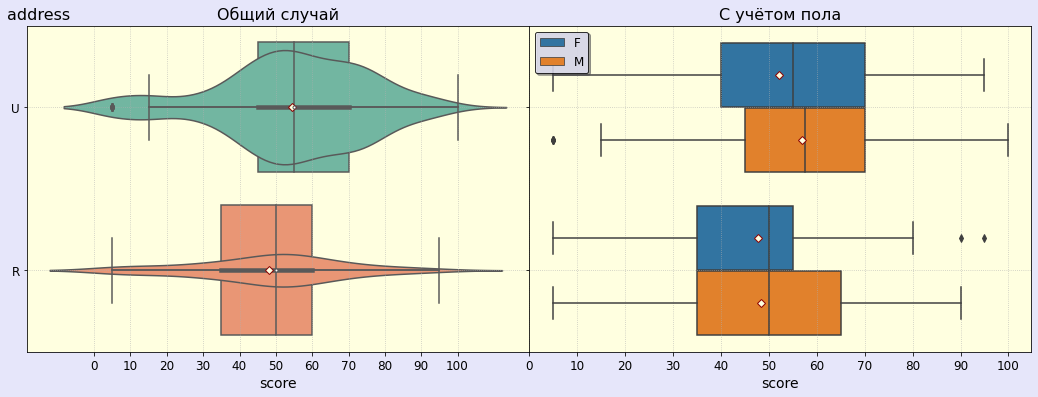

In [14]:
#------------------------------------------------------------------------------#
cols = ["address", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
display(df.isna().sum().iloc[:1])
# Есть 15 пропусков данных в признаке "address".
# Удалим их пока из рабочего датафрема (но не из исходного!).
df = df.dropna(subset=["address"], axis = "index")
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="score", y="address", data=df, ax=ax[0],
            palette="Set2", showmeans=True, meanprops=mean_props)
sns.violinplot(x=df.score, y=df.address, ax=ax[0],
              width=0.7, palette="Set2", scale="count")

sns.boxplot(x="score", y="address", data=df, hue="sex", ax=ax[1],
           showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
[axs.grid("both") for axs in ax]; ax[1].legend(loc="upper left")
[axs.set_xticks(range(0, 110, 10)) for axs in ax]; ax[1].set_ylabel('');
ax[0].set_ylabel("address", rotation=0, position=(0, 1.01), ha="left",
                 fontsize=16)
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола");
#------------------------------------------------------------------------------#
df_gr = df.groupby(["address", "sex"])[["age"]].count()
df_gr = df_gr.join(
    df[df.score < 20].groupby(["address", "sex"])[["score"]].count())
df_gr["в %"] = round(df_gr.score/df_gr.age * 100, 1)
df_gr.columns =["$\downarrow$Всего учеников", "$\downarrow$Двоечники", "в %"]
df_gr

#### 1.3. address. Выводы.
Жизнь за городом - это хорошо. Так хорошо, что несколько отвлекает от учёбы. Первый график показывает, что успеваемость учеников,  
проживающих за городом, ниже, чем у "городских" учеников. Особенно ясно это видно для мальчиков - второй график показывает весьма  
заметное ухудшение успеваемости у "загородных" учеников мужского пола. Дополнительно отметим, что, как видно из таблицы, количество  
двоечников в процентном отношении выше у загородных учеников (особенно у мальчиков).  

Проверим, насколько статистически значимо различие в успеваемости учеников в зависимости от адреса проживания. $\downarrow$

In [15]:
#------------------------------------------------------------------------------#
cols = ["address", "score"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df_urban = df[df.address == "U"].score
df_suburban = df[df.address == "R"].score
print('Feature "address": One-Way ANOVA p-value =',
      f_oneway(df_urban, df_suburban).pvalue.round(3))

Feature "address": One-Way ANOVA p-value = 0.014


Таким образом, адрес проживания оставляем для модели: у детей, живущих в городе и за городом, успеваемость значимо  
различается: $p_{value} < \alpha = 0.05$.

#### 1.4. Размер семьи famsize ('LE3' <= 3, 'GT3' >3).
Есть пропуски данных.

In [16]:
# Признак "famsize" является категориальным признаком ординального типа:
# GT3 > LE3. Нечисловой признак.
na_data_ordinal = ["famsize"]
na_data_ordinal

['famsize']

,famsize
GT3,255
LE3,107


famsize    27
dtype: int64


,famsize
GT3,247
LE3,101


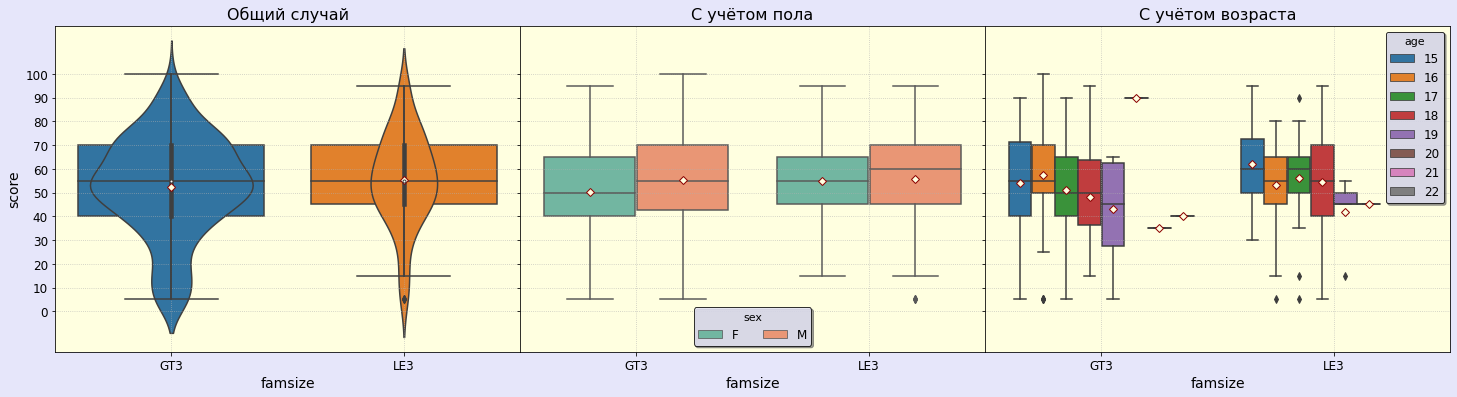

In [17]:
#------------------------------------------------------------------------------#
cols = ["famsize", "address", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
display(pd.DataFrame(df.famsize.value_counts()))
print(df.isna().sum().iloc[:1])
# Есть 27 пропусков данных в признаке "address".
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий:
display(pd.DataFrame(df.famsize.value_counts()))
# Большая семья (GT3) встречается в два с половиной раза чаще, чем "малосемейные".
fig, ax = plt.subplots(1, 3, figsize=(25, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="famsize", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props);
sns.violinplot(x=df.famsize, y=df.score, ax=ax[0], width=0.7,
               scale="count")
sns.boxplot(x="famsize", y="score", data=df, hue="sex", ax=ax[1], 
            showmeans=True, meanprops=mean_props, palette="Set2");
sns.boxplot(x="famsize", y="score", data=df, hue="age", ax=ax[2],
            showmeans=True, meanprops=mean_props);
#------------------------------------------------------------------------------#
[axs.set_yticks(range(0, 110, 10)) for axs in ax];
[axs.grid("both") for axs in ax];
ax[1].set_ylabel(""); ax[2].set_ylabel("");
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола");
ax[2].set_title("С учётом возраста");
ax[1].legend(ncol=2, loc="lower center", title="sex");

#### 1.4. Размер семьи famsize ('LE3' <= 3, 'GT3' >3). Промежуточные выводы.
В общем случае размер семьи слабо влияет на успеваемость. Снижение успеваемости с возрастом - общая тенденция, отмеченная ранее.  
Тем не менее, проверим статистическую значимость категорий признака "famsize" $\downarrow$

In [18]:
#------------------------------------------------------------------------------#
cols = ["famsize", "score"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df_le3 = df[df.famsize == "LE3"].score
df_gt3 = df[df.famsize == "GT3"].score
print('Feature "address": One-Way ANOVA p-value =',
      f_oneway(df_le3, df_gt3).pvalue.round(3))

Feature "address": One-Way ANOVA p-value = 0.239


Таким образом, признак "famsize" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [19]:
features_to_delete.append("famsize")
features_to_delete

['school', 'famsize']

#### 1.5. Pstatus - статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно).
Есть пропуски данных.

In [20]:
# Признак "Pstatus" является категориальным признаком номинального типа:
# Нечисловой признак.
na_data_nominal.append("Pstatus")
na_data_nominal

['school', 'sex', 'address', 'Pstatus']

['A' nan 'T']
Пропуски: 45


,Pstatus
T,308
A,36


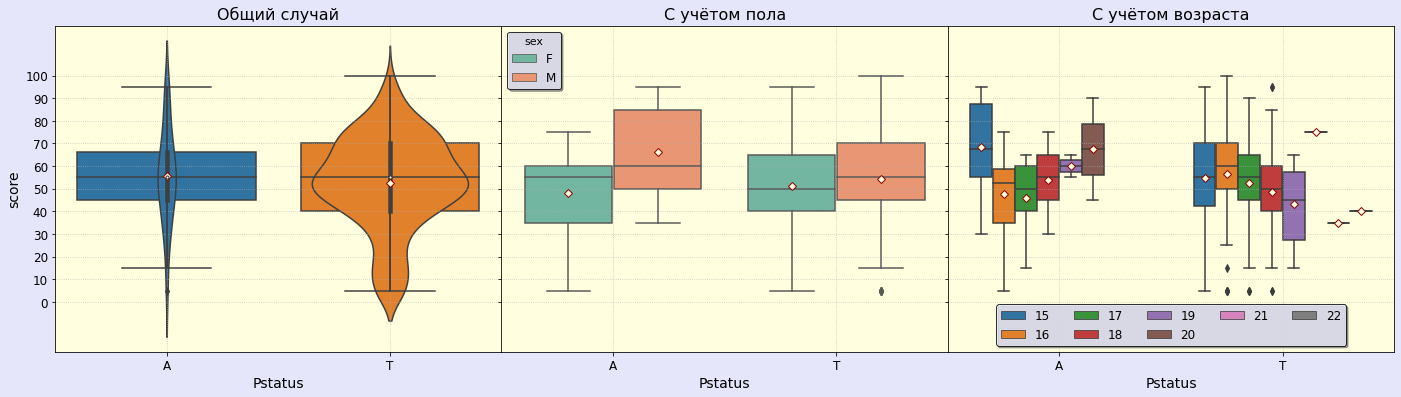

In [21]:
#------------------------------------------------------------------------------#
cols = ["Pstatus", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print(df.Pstatus.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 45 пропусков данных в признаке "Pstatus".
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=["Pstatus"], axis="index")
# Посмотрим на частоту категорий:
display(pd.DataFrame(df.Pstatus.value_counts()))
#------------------------------------------------------------------------------#
# Рассмотрим успеваемость в зависимости от статуса проживания рожителей:
fig, ax = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="Pstatus", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props);
sns.violinplot(x=df.Pstatus, y=df.score, ax=ax[0], width=0.7,
               scale="count")
sns.boxplot(x="Pstatus", y="score", data=df, hue="sex", ax=ax[1], 
            showmeans=True, meanprops=mean_props, palette="Set2");
sns.boxplot(x="Pstatus", y="score", data=df, hue="age", ax=ax[2],
            showmeans=True, meanprops=mean_props);
#------------------------------------------------------------------------------#
[axs.set_yticks(range(0, 110, 10)) for axs in ax];
[axs.grid("both") for axs in ax];
ax[1].set_ylabel(""); ax[2].set_ylabel("");
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола");
ax[2].set_title("С учётом возраста");
ax[2].legend(ncol=5, loc="lower center");

#### 1.5. Pstatus. Промежуточные выводы.
Если в общем случае Pstatus слабо влияет на успеваемость, то учёт пола уже показывает заметную разницу.  
Возраст и вовсе демонстрирует определённую тенденцию.  
* второй график показывает, что в семьях с раздельным проживанием родителей у мальчиков успеваемость существенно выше, чем у девочек.
* на третьем графике видно, что минимальная успеваемость наблюдается у детей возраста 17 лет - в семьях с раздельным проживанием родителей.
* общая тенденция снижения успеваемости с возрастом - хорошо видна в "полных" семьях.

Проверим признак "Pstatus" на статистическую значимость его категорий. Учтём при этом наблюдаемую на втором графике  
разницу в успеваемости у мальчиков и девочек в семьях, живущих раздельно. $\downarrow$

In [22]:
cols = ["Pstatus", "sex", "score"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df_A = df[df.Pstatus == "A"].score
df_T = df[df.Pstatus == "T"].score
print('Feature "Pstatus": One-Way ANOVA p-value =',
      f_oneway(df_A, df_T).pvalue.round(3))
# Учтём пол:
df_A_male = df[(df.Pstatus == "A")&(df.sex == "M")].score
df_A_female = df[(df.Pstatus == "A")&(df.sex == "F")].score
df_T_male = df[(df.Pstatus == "T")&(df.sex == "M")].score
df_T_female = df[(df.Pstatus == "T")&(df.sex == "F")].score
print('Feature "Pstatus" & "sex": One-Way ANOVA p-value =',
      f_oneway(df_A_male, df_A_female, df_T_male, df_T_female).pvalue.round(3))
#------------------------------------------------------------------------------#

Feature "Pstatus": One-Way ANOVA p-value = 0.419
Feature "Pstatus" & "sex": One-Way ANOVA p-value = 0.03


Таким образом, учёт пола учеников в семьях, проживающих раздельно, значимо влияет на успеваемость: $p_{value} < \alpha = 0.05$.
Оставляем признак "Pstatus" в модели.  
Конечно, надо проводить двухфакторный дисперсионный анализ, но у меня просто не осталось времени на это - хочется уже сдать проект.

#### 1.6. Medu и Fedu - образование матери и отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее).
Есть пропуски данных.

Образование матери: [ 4.  1.  3.  2. nan  0.]
Образование отца: [ 4.  1.  2.  3. 40. nan  0.]
Образование отца (после замены выброса): [ 4.  1.  2.  3. nan  0.]

Пропуски:
Medu     3
Fedu    24
dtype: int64


,Medu,Fedu
0.0,3,2
1.0,53,74
2.0,96,104
3.0,89,93
4.0,121,89


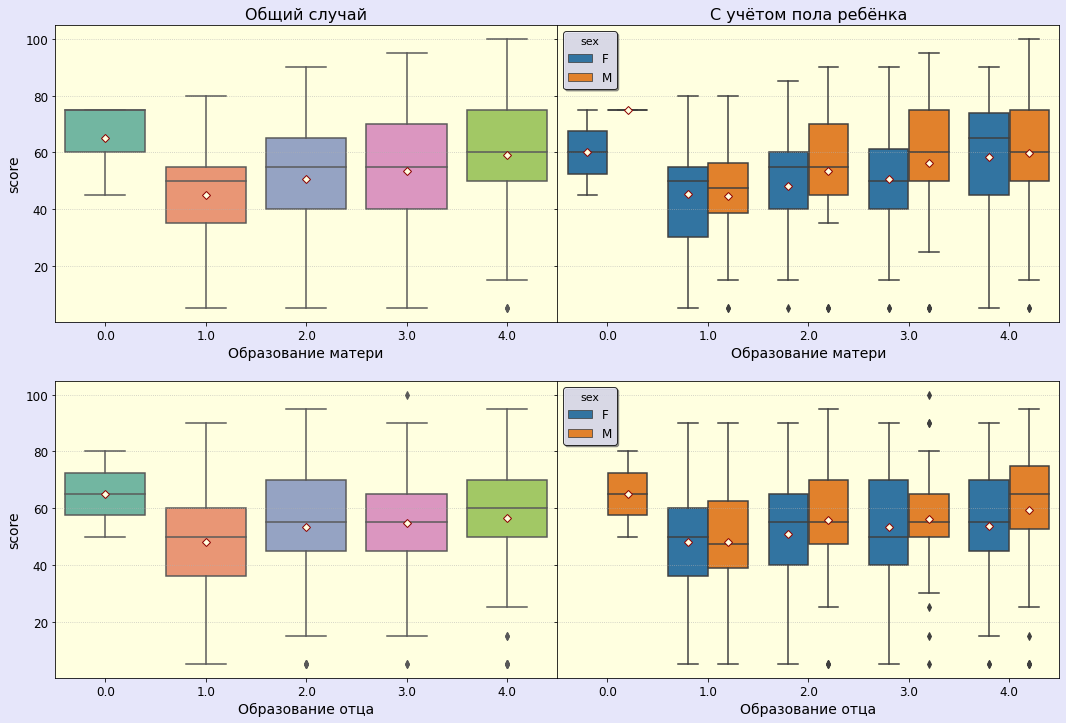

In [23]:
#------------------------------------------------------------------------------#
# По сути, Medu и Fedu - признаки ординального типа, но категории этих признаков
# уже преобразованы в числа.
cols = ["Medu", "Fedu", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Образование матери:", df.Medu.unique())
print("Образование отца:", df.Fedu.unique())
# Признак "Fedu" содержит выброс 40. Заменим его на 4:
df.Fedu = df.Fedu.replace(40, 4)
print("Образование отца (после замены выброса):", df.Fedu.unique())
###print('\nПропуски:'); print(df.isna().sum().iloc[:2])
print('\nПропуски:\n', df.isna().sum().iloc[:2], sep='')
#Есть 3 пропуска в признаке "Medu" и 24 пропуска в "Fedu"
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=["Medu", "Fedu"], axis="index")
# Посмотрим на частоту категорий:
df_vc = pd.DataFrame(df.Medu.value_counts()).join(
        pd.DataFrame(df.Fedu.value_counts()))
display(df_vc.sort_index())
# Наибольшее количество мам - с высшим ообразованием.
# У пап наибольшее количество с неоконченным средним образованием: 5-9 классы.
#------------------------------------------------------------------------------#
# Рассмотрим успеваемость в зависимости от образования родителей:
fig, ax = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="Medu", y="score", data=df, ax=ax[0, 0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="Medu", y="score", hue="sex", data=df, ax=ax[0, 1],
            showmeans=True, meanprops=mean_props)
sns.boxplot(x="Fedu", y="score", data=df, ax=ax[1, 0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="Fedu", y="score", hue="sex", data=df, ax=ax[1, 1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
[ax[i, 1].set_ylabel("") for i in (0, 1)]
ax[0, 0].set_title("Общий случай"); ax[0, 1].set_title("С учётом пола ребёнка")
[ax[0, i].set_xlabel("Образование матери") for i in (0, 1)]
[ax[1, i].set_xlabel("Образование отца") for i in (0, 1)];

#### 1.6. Medu и Fedu. Промежуточные выводы.
Тенденция налицо - чем выше ообразование хотя бы одного из родителей, тем больше успеваемость ребёнка.  
Любопытный результат наблюдается для детей, у которых кто-то из родителей не имеет образования, - успеваемость таких детей весьма высокая.  

*Уточним данные, рассмотрев успеваемость тех детей, у которых оба родителя имеют одинаковое образование.* $\downarrow$

,Medu,Fedu
1.0,34,34
2.0,47,47
3.0,33,33
4.0,63,63


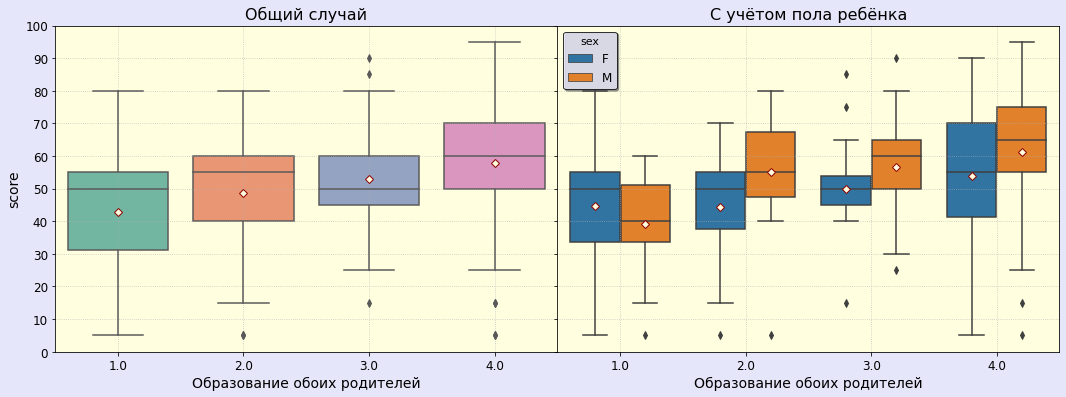

In [24]:
df_eq = df.query("Fedu == Medu")
display(pd.DataFrame(df_eq.Medu.value_counts().sort_index()).join(
        pd.DataFrame(df_eq.Fedu.value_counts().sort_index())))
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="Medu", y="score", data=df_eq, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="Medu", y="score", hue="sex", data=df_eq, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Образование обоих родителей") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax];

Проверим признаки "Medu" и "Fedu" на статистическую значимость их категорий. Сделаем для случая, когда у родителей  
одинаковый уровень образования. $\downarrow$

In [25]:
#------------------------------------------------------------------------------#
cols = ["Fedu", "Medu", "score"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
df_FM_1 = df.query("Fedu == Medu & Fedu == 1").score
df_FM_2 = df.query("Fedu == Medu & Fedu == 2").score
df_FM_3 = df.query("Fedu == Medu & Fedu == 3").score
df_FM_4 = df.query("Fedu == Medu & Fedu == 4").score
print('Features "Fedu" = "Medu": One-Way ANOVA p-value =',
      f_oneway(df_FM_1, df_FM_2, df_FM_3, df_FM_4).pvalue.round(3))

Features "Fedu" = "Medu": One-Way ANOVA p-value = 0.002


Таким образом, признаки "Fedu" и "Medu" оставляем в модели: $p_{value} < \alpha = 0.05$

#### 1.7. Mjob и Fjob - работа родителей ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое).
Есть пропуски данных.

In [26]:
# Признаки "Mjob" и "Fjob " являются категориальными номинального типа.
# Нечисловой признак.
na_data_nominal.append("Mjob"); na_data_nominal.append("Fjob")
na_data_nominal

['school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob']

Работа матери: ['at_home' 'health' 'other' 'services' 'teacher' nan]
Работа отца: ['teacher' 'other' nan 'health' 'services' 'at_home']

Пропуски:
Mjob    19
Fjob    36
dtype: int64


,Mjob,Fjob
at_home,52,15
health,26,15
other,116,182
services,88,95
teacher,53,28


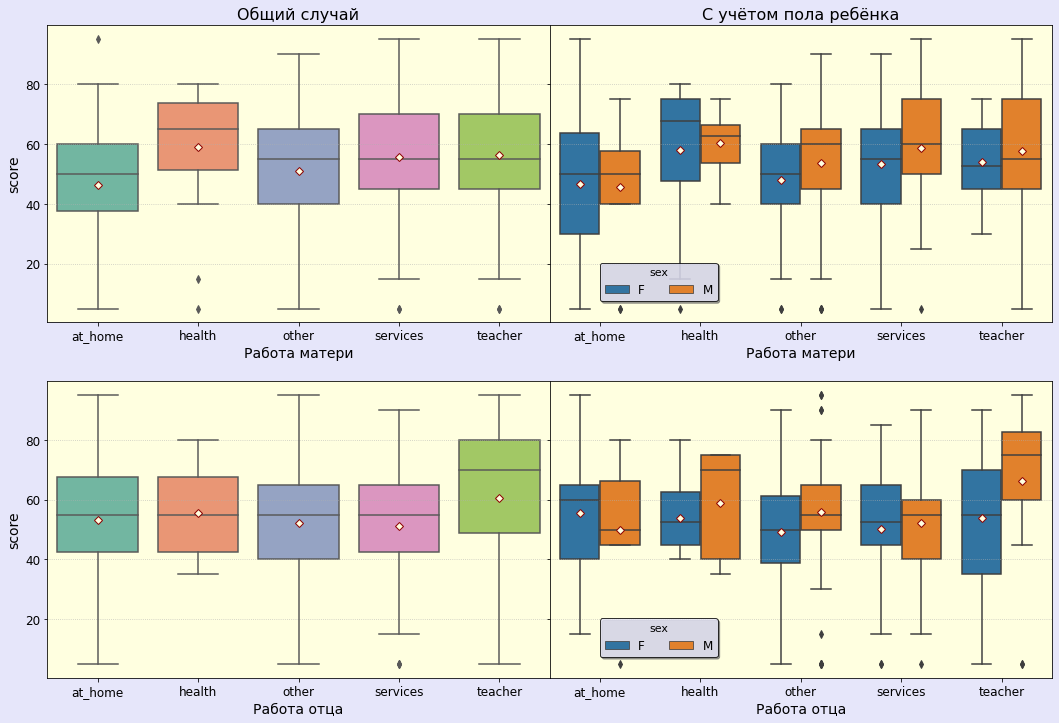

In [27]:
#------------------------------------------------------------------------------#
cols = ["Mjob", "Fjob", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Работа матери:", df.Mjob.unique())
print("Работа отца:", df.Fjob.unique())
print('\nПропуски:\n', df.isna().sum().iloc[:2], sep='')
# Есть 19 пропусков в признаке "Mjob" и 36 пропусков в "Fjob"
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=["Mjob", "Fjob"], axis="index")
# Посмотрим на частоту категорий:
df_vc = pd.DataFrame(df.Mjob.value_counts()).join(
        pd.DataFrame(df.Fjob.value_counts()))
display(df_vc.sort_index())
# Наибольшее количество видов работы мам и пап - other.
#------------------------------------------------------------------------------#
# Рассмотрим успеваемость в зависимости от работы родителей:
fig, ax = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
##df1 = df.query("score > 0 & age < 20")
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
df1 = df.sort_values(by="Mjob")
sns.boxplot(x="Mjob", y="score", data=df1, ax=ax[0, 0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="Mjob", y="score", hue="sex", data=df1, ax=ax[0, 1],
            showmeans=True, meanprops=mean_props, hue_order=["F", "M"])
df1 = df.sort_values(by="Fjob")
sns.boxplot(x="Fjob", y="score", data=df1, ax=ax[1, 0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="Fjob", y="score", hue="sex", data=df1, ax=ax[1, 1],
            showmeans=True, meanprops=mean_props, hue_order=["F", "M"])
#------------------------------------------------------------------------------#
[ax[i, 1].set_ylabel("") for i in (0, 1)]
ax[0, 0].set_title("Общий случай"); ax[0, 1].set_title("С учётом пола ребёнка")
[ax[0, i].set_xlabel("Работа матери") for i in (0, 1)]
[ax[1, i].set_xlabel("Работа отца") for i in (0, 1)]
ax[0, 1].legend(loc=(0.1, 0.07), title="sex", ncol=2)
ax[1, 1].legend(loc=(0.1, 0.07), title="sex", ncol=2);

#### 1.7. Mjob и Fjob. Промежуточные выводы.
Если работа матери связана с медициной ("health"), успеваемость выше. В случае с работой отца наибольшая успеваемость наблюдается  
у детей учителя, причём успеваемость мальчиков существенно лучше, чем девочек.

*Уточним данные, рассмотрев успеваемость тех детей, у которых оба родителя имеют одинаковую работу.* $\downarrow$

,Работа родителей
other,85
services,40
teacher,11
at_home,5
health,3


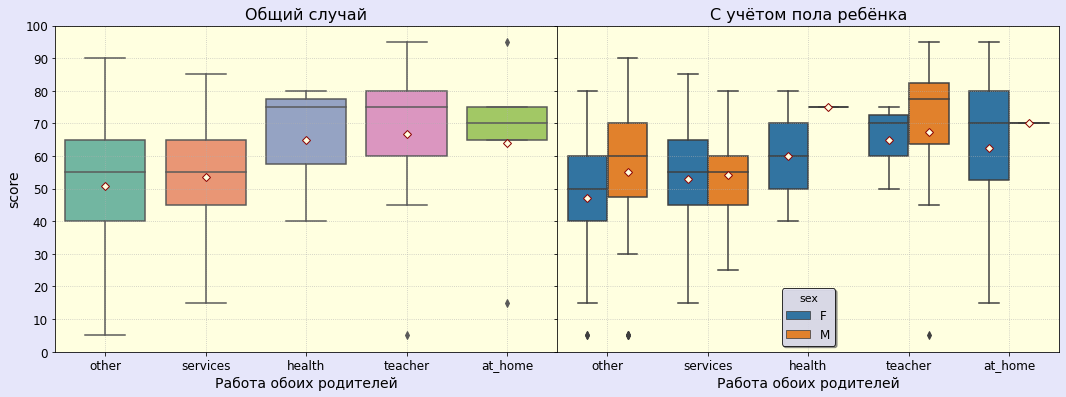

In [28]:
df_eq = df.query("Fjob == Mjob")
##df1 = df_eq.query("score > 0 & age < 20")
df_vc = pd.DataFrame(df_eq.Fjob.value_counts())
df_vc.columns = ["Работа родителей"]
display(df_vc)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="Fjob", y="score", data=df_eq, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="Fjob", y="score", hue="sex", data=df_eq, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Работа обоих родителей") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax];
ax[1].legend(loc="lower center", title="sex");

Проверим признаки "Mjob" и "Fjob" на статистическую значимость их категорий. $\downarrow$

In [29]:
#------------------------------------------------------------------------------#
cols = ["Mjob", "Fjob", "score"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
# Для работы матери:
df_Mjob_1 = df[df.Mjob == "other"].score
df_Mjob_2 = df[df.Mjob == "services"].score
df_Mjob_3 = df[df.Mjob == "health"].score
df_Mjob_4 = df[df.Mjob == "teacher"].score
df_Mjob_5 = df[df.Mjob == "at_home"].score
print('Features "Mjob": One-Way ANOVA p-value =',
f_oneway(df_Mjob_1, df_Mjob_2, df_Mjob_3, df_Mjob_4, df_Mjob_5).pvalue.round(3))
# Для работы отца:
df_Fjob_1 = df[df.Fjob == "other"].score
df_Fjob_2 = df[df.Fjob == "services"].score
df_Fjob_3 = df[df.Fjob == "health"].score
df_Fjob_4 = df[df.Fjob == "teacher"].score
df_Fjob_5 = df[df.Fjob == "at_home"].score
print('Features "Fjob": One-Way ANOVA p-value =',
f_oneway(df_Fjob_1, df_Fjob_2, df_Fjob_3, df_Fjob_4, df_Fjob_5).pvalue.round(3))
# Посмотрим, что даёт тест Стьюдента:
get_stud_test(df, "Mjob")
get_stud_test(df, "Fjob")

Features "Mjob": One-Way ANOVA p-value = 0.014
Features "Fjob": One-Way ANOVA p-value = 0.277
Не найдено статистически значимых различий для "Mjob".
Не найдено статистически значимых различий для "Fjob".


Любопытная ситуация наблюдается для признаков "Mjob" и "Fjob":
* Для "Mjob" one-way ANOVA даёт статистически значимые различия категорий этого признака: $p_{value} < \alpha = 0.05$. Однако тест Стьюдента
показывает, что основная гипотеза верна - нет статистически значимых различий. Понятно, что причиной такого результата теста Стьюдента
является введение поправки (Бонферрони) на множественное сравнение выборок. Признак "Mjob" имеет 5 категорий, следовательно, количество
парных сравнений равно числу сочетаний из 5 по 2: $C_{5}^2 = \frac{5!}{2!\,3!} = 10$. Другими словами, поправка Бонферрони на порядок уменьшает
уровень значимости $\alpha$, увеличивая тем самым область справедливости нулевой гипотезы. В то же время, one-way ANOVA не нуждается в
подобных поправках, для ANOVA $\alpha = 0.05$, и нулевая гипотеза отвергается для признака "Mjob".
* Для "Fjob" всё просто - для этого признака $p_{value}$ весьма велика, и нулевая гипотеза остаётся в силе.

Однако мы оставим для модели оба признака "Mjob" и "Fjob". Это может пригодиться для процедуры заполнения пропусков данных.

#### 1.8. reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое).
Есть пропуски.

In [30]:
# Признак "reason" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("reason")
na_data_nominal

['school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason']

Категории: ['course' 'other' 'home' 'reputation' nan]
Пропуски: 17


,reason,F,M
course,135,67,68
home,101,48,53
other,34,18,16
reputation,102,63,39


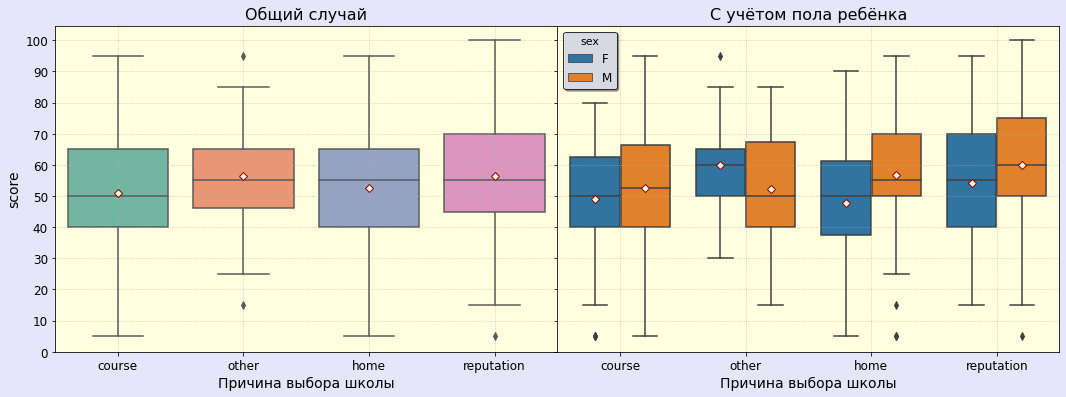

In [31]:
#------------------------------------------------------------------------------#
cols = ["reason", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.reason.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 17 пропусков в признаке "reason".
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=["reason"], axis="index")
# Посмотрим на частоту категорий и пол:
df_vc = pd.DataFrame(df.reason.value_counts()).sort_index()
df_pvt = df.pivot_table(index="reason", columns="sex", values="score",
                        aggfunc="count")
display(df_vc.join(df_pvt))
# Наболее частая причина выбора школы - образовательная программа (course).
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="reason", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="reason", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Причина выбора школы") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax];

#### 1.8. reason. Промежуточные выводы.
В общем случае (левый график) визуальные различия невелики. Однако справа видно, что успеваемость заметно различается  
у мальчиков и девочек в категориях "близость к дому" (home) и "другие причины выбора школы" (other).  
Проверим на статистически значимые различия. $\downarrow$

In [32]:
#------------------------------------------------------------------------------#
cols = ["reason", "sex", "score"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
# Общий случай:
df_course = df[df.reason == "course"].score
df_other = df[df.reason == "other"].score
df_home = df[df.reason == "home"].score
df_rep = df[df.reason == "reputation"].score
print('Feature "reason": One-Way ANOVA p-value =',
      f_oneway(df_course, df_other, df_home, df_rep).pvalue.round(3))
# С учётом пола:
df_c_M = df[(df.reason == "course")&(df.sex == "M")].score
df_c_F = df[(df.reason == "course")&(df.sex == "F")].score
df_o_M = df[(df.reason == "other")&(df.sex == "M")].score
df_o_F = df[(df.reason == "other")&(df.sex == "F")].score
df_h_M = df[(df.reason == "home")&(df.sex == "M")].score
df_h_F = df[(df.reason == "home")&(df.sex == "F")].score
df_r_M = df[(df.reason == "reputation")&(df.sex == "M")].score
df_r_F = df[(df.reason == "reputation")&(df.sex == "F")].score
print('Features "reason" & "sex": One-Way ANOVA p-value =',
      f_oneway(df_c_M, df_c_F, df_o_M, df_o_F, df_h_M, df_h_F,
               df_r_M, df_r_F).pvalue.round(3))

Feature "reason": One-Way ANOVA p-value = 0.17
Features "reason" & "sex": One-Way ANOVA p-value = 0.063


Таким образом, признак "reason" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$, хоть и не сильно больше.

In [33]:
features_to_delete.append("reason")
features_to_delete

['school', 'famsize', 'reason']

#### 1.9. guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое).
Есть пропуски данных.

In [34]:
# Признак "guardian" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("guardian")
na_data_nominal

['school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']

Категории: ['mother' 'father' 'other' nan]
Пропуски: 31


,guardian
father,86
mother,248
other,24


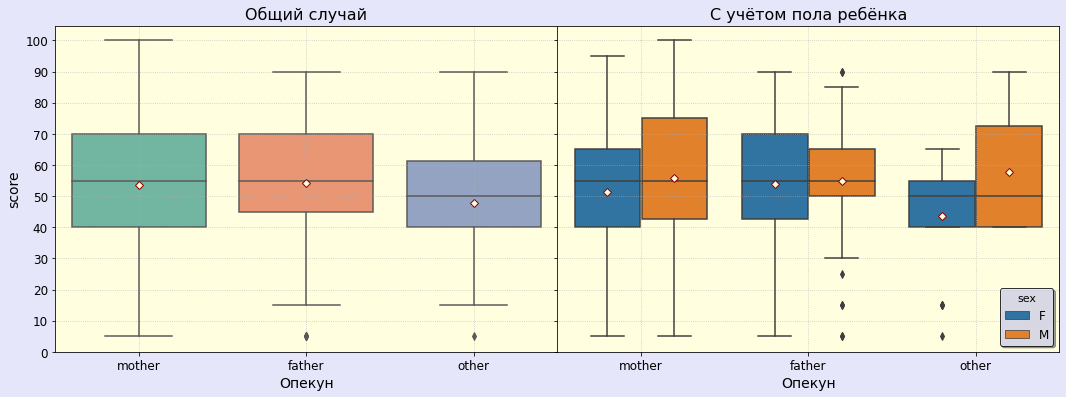

In [35]:
#------------------------------------------------------------------------------#
cols = ["guardian", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.guardian.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 31 пропуск в признаке "reason".
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=["guardian"], axis="index")
# Посмотрим на частоту категорий:
df_vc = pd.DataFrame(df.guardian.value_counts())
display(df_vc.sort_index())
# Наболее частая причина выбора школы - образовательная программа (course).
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
#df1 = df.query("score > 0 & age < 20")
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="guardian", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="guardian", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Опекун") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax];
#ax[1].legend(ncol=2, loc="lower center", title="sex");

#### 1.9. guardian. Промежуточные выводы.
Можно отметить некоторую тенденцию к снижению успеваемости - в случае, когда опекун "other", т.е. не отец и не мать.  
*Любопытная ситуация наблюдается в некоторых семьях (16 семей) - когда семья полная, но ни мать, ни отец не являются опекунами.* $\downarrow$

In [36]:
cols = ['Pstatus', 'guardian', "score"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset = cols, axis = 'index')
df = df[(df.Pstatus=='T') & (df.guardian=='other')]
display(df, df.count())

,Pstatus,guardian,score
127,T,other,45.0
152,T,other,50.0
192,T,other,40.0
251,T,other,50.0
296,T,other,15.0
297,T,other,40.0
304,T,other,65.0
305,T,other,60.0
309,T,other,50.0
310,T,other,15.0


Pstatus     16
guardian    16
score       16
dtype: int64

Проверим категории признака "guardian" на статистически значимые различия. $\downarrow$

In [37]:
cols = ["guardian", "score"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
#------------------------------------------------------------------------------#
df_mother = df[df.guardian == "mother"].score
df_other = df[df.guardian == "other"].score
df_father = df[df.guardian == "father"].score
print('Feature "guardian": One-Way ANOVA p-value =',
      f_oneway(df_mother, df_other, df_father).pvalue.round(3))

Feature "guardian": One-Way ANOVA p-value = 0.385


Таким образом, признак "guardian" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [38]:
features_to_delete.append("guardian")
features_to_delete

['school', 'famsize', 'reason', 'guardian']

#### 1.10. traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.).

Категории: [ 2.  1.  3. nan  4.]
Пропуски: 28


,traveltime
1.0,239
2.0,94
3.0,21
4.0,7


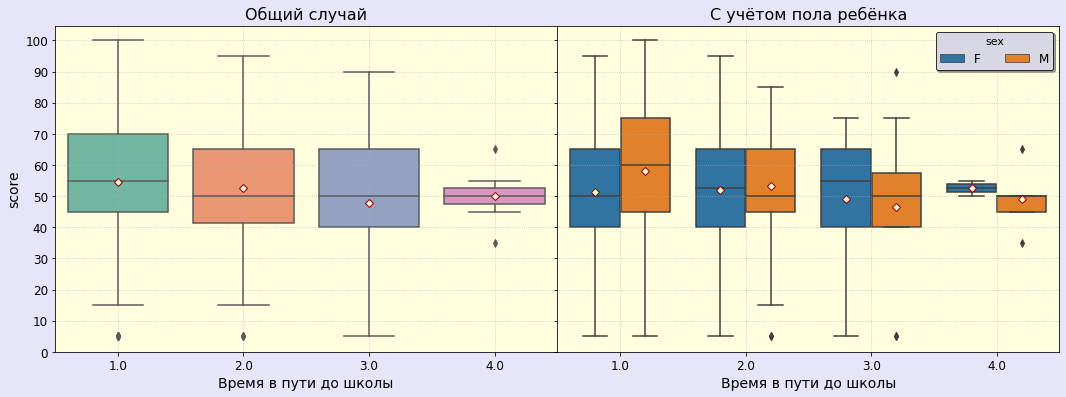

In [39]:
# По сути, traveltime - признак ординального типа, но категории этого признака
# уже преобразованы в числа.
#------------------------------------------------------------------------------#
cols = ["traveltime", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.traveltime.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 28 пропусков в признаке "traveltime".
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=["traveltime"], axis="index")
# Посмотрим на частоту категорий:
df_vc = pd.DataFrame(df.traveltime.value_counts()).sort_index()
display(df_vc)
# Большая часть учеников живёт рядом со школой.
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="traveltime", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="traveltime", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Время в пути до школы") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(ncol=2, loc="upper right", title="sex");

#### 1.10. traveltime. Промежуточные выводы.
В общем случае, судя по средним баллам, наблюдается тенденция к снижению успеваемости с увеличением времени в пути до школы.  
Исключением являются те ученики, кто добирается до школы дольше всех, хотя их не много.
Проверим категории признака на статистически значимые различия. $\downarrow$

In [40]:
cols = ["traveltime", "score", "sex", "age"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
#------------------------------------------------------------------------------#
df_1 = df[df.traveltime == 1].score
df_2 = df[df.traveltime == 2].score
df_3 = df[df.traveltime == 3].score
df_4 = df[df.traveltime == 4].score
print('Feature "traveltime": One-Way ANOVA p-value =',
      f_oneway(df_1, df_2, df_3, df_4).pvalue.round(3))

Feature "traveltime": One-Way ANOVA p-value = 0.486


Таким образом, признак "traveltime" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [41]:
features_to_delete.append("traveltime")
features_to_delete

['school', 'famsize', 'reason', 'guardian', 'traveltime']

#### 1.11. "studytime" и "studytime, granular" - время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов).
Признак "studytime, granular" искусственно введён в исходную базу данных.

In [42]:
# По сути, studytime - признак ординального типа, но категории этого признака
# уже преобразованы в числа.
#------------------------------------------------------------------------------#
cols = ["studytime, granular", "studytime", "score", "sex"]
df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.studytime.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 7 пропусков в признаке "studytime".
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий:
df_vc = pd.DataFrame(df.studytime.value_counts()).sort_index()
display(df_vc)
# Большая часть учеников имеет в неделю от 2 до 5 часов времени на учёбу.
#------------------------------------------------------------------------------#
# Разберёмся с признаком "studytime, granular":
df1 = pd.DataFrame(df["studytime, granular"].value_counts()).sort_index(
    ascending=False).reset_index()
df2 = pd.DataFrame(df["studytime"].value_counts()).sort_index().reset_index()
df3 = df1.join(df2, rsuffix="_study")
display(df3)

Категории: [ 2.  3.  1. nan  4.]
Пропуски: 7


,studytime
1.0,103
2.0,189
3.0,63
4.0,27


,index,"studytime, granular",index_study,studytime
0,-3.0,103,1.0,103
1,-6.0,189,2.0,189
2,-9.0,63,3.0,63
3,-12.0,27,4.0,27


Таким образом, имеем абсолютно детерминированную связь:  
$"studytime, granular"\;=\;"studytime"\;*\;(-3)$  
Следует ожидать "абсолютную" корреляцию этих признаков.

In [43]:
df[["studytime, granular", "studytime"]].corr()

,"studytime, granular",studytime
"studytime, granular",1.0,-1.0
studytime,-1.0,1.0


Так и есть. Удалим признак "studytime, granular" из модели.

In [44]:
features_to_delete.append("studytime, granular")
features_to_delete

['school',
 'famsize',
 'reason',
 'guardian',
 'traveltime',
 'studytime, granular']

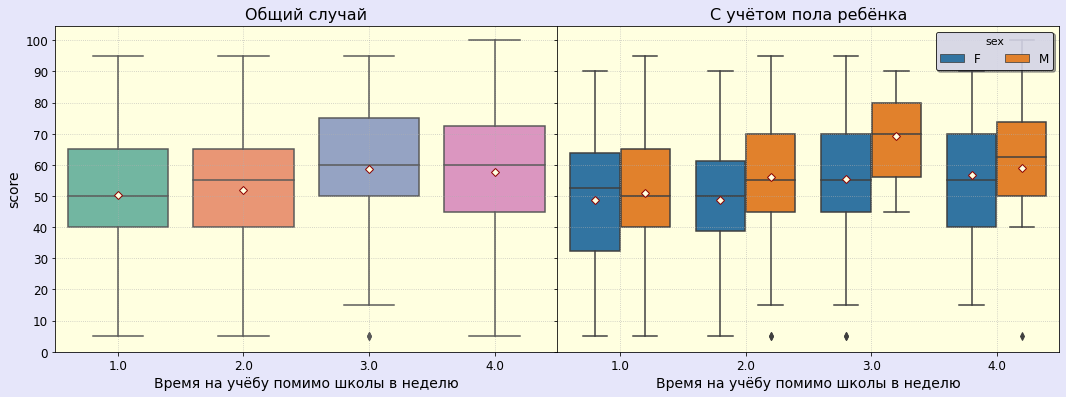

In [45]:
#------------------------------------------------------------------------------#
cols = ["studytime", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="studytime", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="studytime", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Время на учёбу помимо школы в неделю") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(ncol=2, loc="upper right", title="sex");

#### 1.11. studytime. Промежуточные выводы.
В общем случае, судя по средним баллам, наблюдается тенденция к увеличению успеваемости с увеличением времени на учёбу помимо школы.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [46]:
cols = ["studytime", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_1 = df[df.studytime == 1].score
df_2 = df[df.studytime == 2].score
df_3 = df[df.studytime == 3].score
df_4 = df[df.studytime == 4].score
print('Feature "studytime": One-Way ANOVA p-value =',
      f_oneway(df_1, df_2, df_3, df_4).pvalue.round(3))

Feature "studytime": One-Way ANOVA p-value = 0.043


Таким образом, признак "studytime" включаем в модель: $p_{value} < \alpha = 0.05$.

#### 1.12 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0).

Категории: [ 0.  3. nan  2.  1.]
Пропуски: 22


,failures
0.0,290
1.0,48
2.0,15
3.0,14


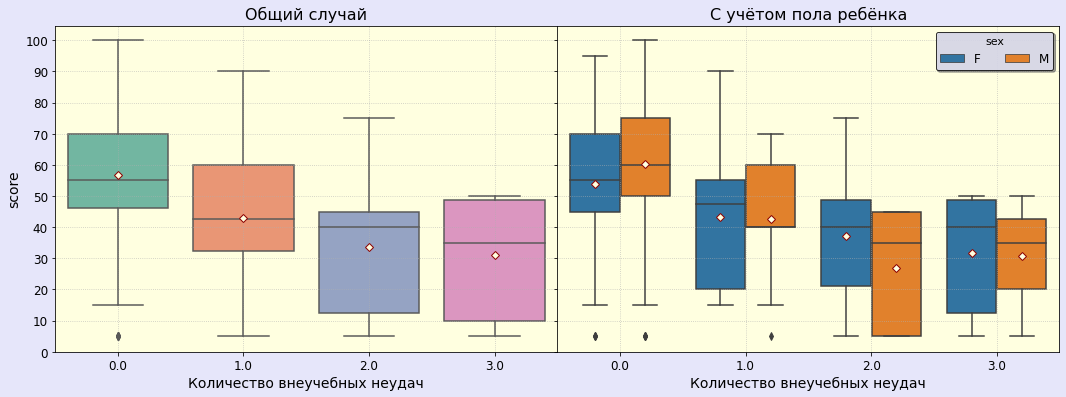

In [47]:
# По сути, failures - признак ординального типа, но категории этого признака
# уже преобразованы в числа.
#------------------------------------------------------------------------------#
cols = ["failures", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.failures.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 22 пропуска.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий:
df_vc = pd.DataFrame(df.failures.value_counts()).sort_index()
display(df_vc)
# Большая часть учеников не имеет внеучебных неудач.
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="failures", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="failures", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Количество внеучебных неудач") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(ncol=2, loc="upper right", title="sex");

#### 1.12. failures. Промежуточные выводы.
В общем случае, наблюдается ярко выраженная зависимость успеваемости от количества внеучебных неудач - успеваемость сильно снижается  
с ростом количества неудач.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [48]:
cols = ["failures", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_0 = df[df.failures == 0].score
df_1 = df[df.failures == 1].score
df_2 = df[df.failures == 2].score
df_3 = df[df.failures == 3].score
print('Feature "failures": One-Way ANOVA p-value =',
      f_oneway(df_0, df_1, df_2, df_3).pvalue.round(3))

Feature "failures": One-Way ANOVA p-value = 0.0


Таким образом, признак "failures" включаем в модель: $p_{value} < \alpha = 0.05$.

#### 1.13. schoolsup — дополнительная образовательная поддержка (yes или no). 

In [49]:
# Признак "schoolsup" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("schoolsup")
na_data_nominal

['school',
 'sex',
 'address',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup']

Категории: ['yes' 'no' nan]
Пропуски: 9


sex,F,M,All
schoolsup,,,
no,166,165,331
yes,34,15,49
All,200,180,380


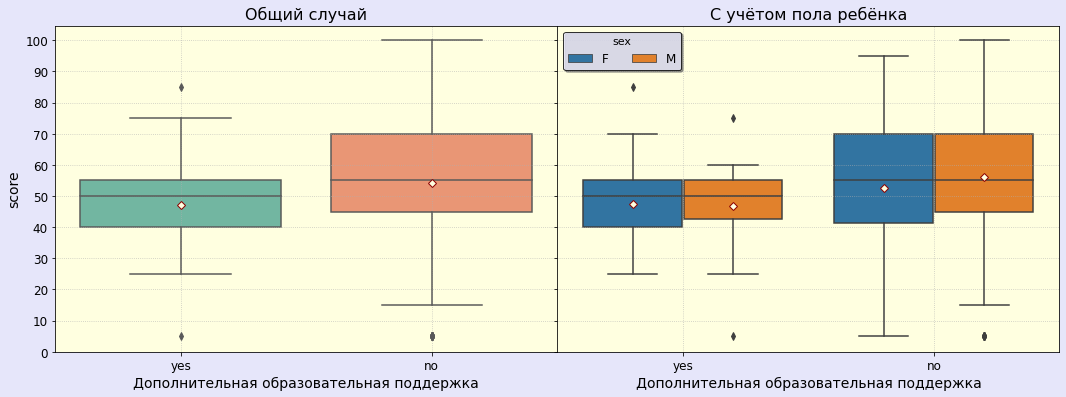

In [50]:
#------------------------------------------------------------------------------#
cols = ["schoolsup", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.schoolsup.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 22 пропуска.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="schoolsup", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
# Большая часть учеников не имеет дополнительной образовательной поддержки.
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="schoolsup", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="schoolsup", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Дополнительная образовательная поддержка") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(ncol=2, title="sex");

#### 1.12. schoolsup. Промежуточные выводы.
В общем случае, успеваемость у учеников с дополнительной образовательной поддержкой - ниже, чем у учеников без поддержки.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [51]:
cols = ["schoolsup", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_yes = df[df.schoolsup == "yes"].score
df_no = df[df.schoolsup == "no"].score
print('Feature "schoolsup": One-Way ANOVA p-value =',
      f_oneway(df_yes, df_no).pvalue.round(3))

Feature "schoolsup": One-Way ANOVA p-value = 0.027


Таким образом, признак "schoolsup" включаем в модель: $p_{value} < \alpha = 0.05$.

#### 1.14. famsup — семейная образовательная поддержка (yes или no).

In [52]:
# Признак "famsup" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("famsup")
na_data_nominal

['school',
 'sex',
 'address',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup']

Категории: ['no' 'yes' nan]
Пропуски: 38


sex,F,M,All
famsup,,,
no,56,79,135
yes,123,93,216
All,179,172,351


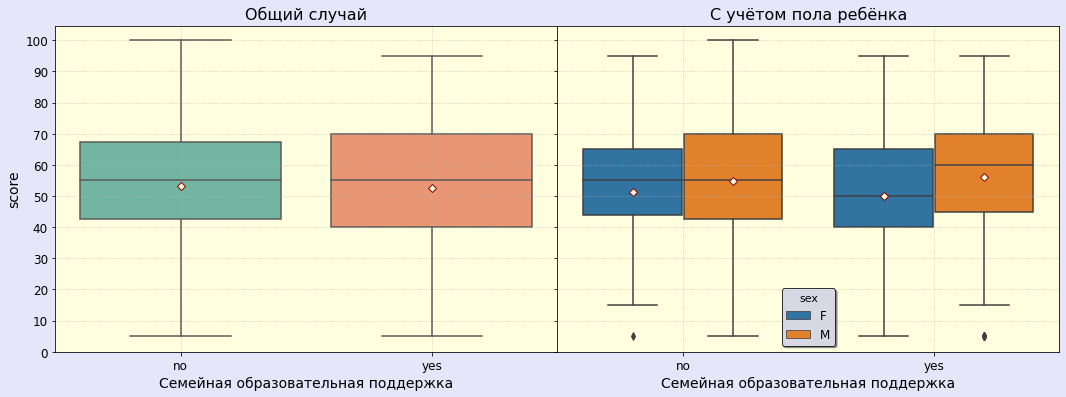

In [53]:
#------------------------------------------------------------------------------#
cols = ["famsup", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.famsup.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 38 пропусков.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="famsup", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
# Большая часть учеников имеет семейную образовательную поддержку.
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="famsup", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="famsup", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Семейная образовательная поддержка") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.13. famsup. Промежуточные выводы.
В общем случае, нет особых различий в успеваемости учеников с поддержкой и без неё.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [54]:
cols = ["famsup", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_yes = df[df.famsup == "yes"].score
df_no = df[df.famsup == "no"].score
print('Feature "famsup": One-Way ANOVA p-value =',
      f_oneway(df_yes, df_no).pvalue.round(3))

Feature "famsup": One-Way ANOVA p-value = 0.724


Таким образом, признак "famsup" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [55]:
features_to_delete.append("famsup")
features_to_delete

['school',
 'famsize',
 'reason',
 'guardian',
 'traveltime',
 'studytime, granular',
 'famsup']

#### 1.14. paid — дополнительные платные занятия по математике (yes или no).

In [56]:
# Признак "paid" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("paid")
na_data_nominal

['school',
 'sex',
 'address',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid']

Категории: ['no' nan 'yes']
Пропуски: 39


sex,F,M,All
paid,,,
no,96,101,197
yes,90,63,153
All,186,164,350


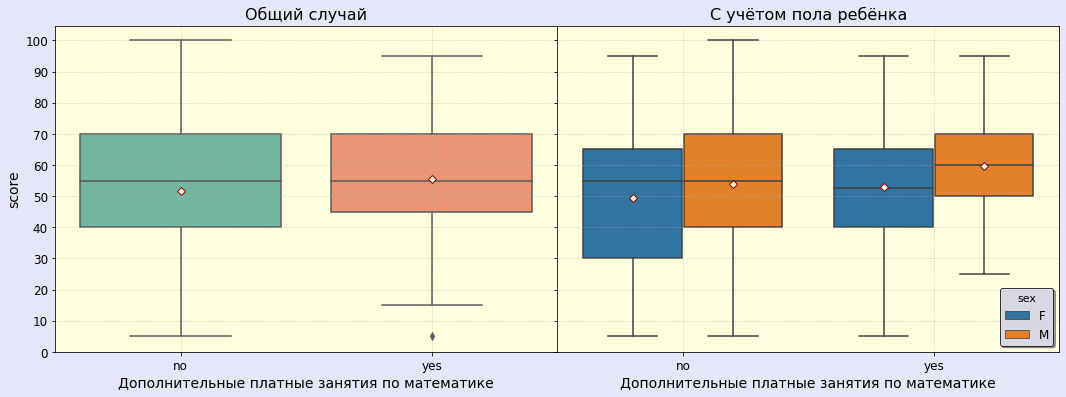

In [57]:
#------------------------------------------------------------------------------#
cols = ["paid", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.paid.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 39 пропусков.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="paid", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
# Большая часть учеников имеет семейную образовательную поддержку.
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="paid", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="paid", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Дополнительные платные занятия по математике") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.14. paid. Промежуточные выводы.
В общем случае, наблюдается увеличение успеваемости у тех учеников, кто берёт дополнительные платные уроки по математике.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [58]:
cols = ["paid", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_yes = df[df.paid == "yes"].score
df_no = df[df.paid == "no"].score
print('Feature "paid": One-Way ANOVA p-value =',
      f_oneway(df_yes, df_no).pvalue.round(3))
#------------------------------------------------------------------------------#
# С учётом пола:
df_yes_M = df[(df.paid == "yes")&(df.sex == "M")].score
df_yes_F = df[(df.paid == "yes")&(df.sex == "F")].score
df_no_M = df[(df.paid == "no")&(df.sex == "M")].score
df_no_F = df[(df.paid == "no")&(df.sex == "F")].score
print('Feature "paid" with "sex": One-Way ANOVA p-value =',
      f_oneway(df_yes_M, df_yes_F, df_no_M, df_no_F).pvalue.round(3))

Feature "paid": One-Way ANOVA p-value = 0.079
Feature "paid" with "sex": One-Way ANOVA p-value = 0.027


Таким образом, признак "paid" включаем в модель: $p_{value} < \alpha = 0.05$ с учётом пола.

#### 1.15. activities — дополнительные внеучебные занятия (yes или no).

In [59]:
# Признак "activities" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("activities")
na_data_nominal

['school',
 'sex',
 'address',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities']

Категории: ['no' 'yes' nan]
Пропуски: 14


sex,F,M,All
activities,,,
no,108,75,183
yes,90,102,192
All,198,177,375


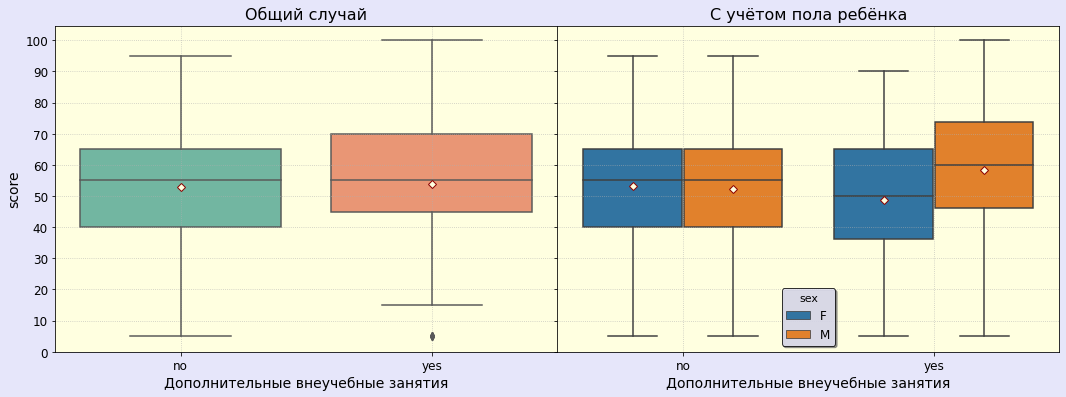

In [60]:
#------------------------------------------------------------------------------#
cols = ["activities", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.activities.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 14 пропусков.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="activities", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="activities", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="activities", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Дополнительные внеучебные занятия") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.15. activities. Промежуточные выводы.
В общем случае, наблюдается некоторое увеличение успеваемости у тех учеников, у кого есть дополнительные внеучебные занятия.  
Особенно сильно отличается успеваемость у мальчиков с дополнительными занятиями от девочек.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [61]:
cols = ["activities", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_yes = df[df.activities == "yes"].score
df_no = df[df.activities == "no"].score
print('Feature "activities": One-Way ANOVA p-value =',
      f_oneway(df_yes, df_no).pvalue.round(3))
#------------------------------------------------------------------------------#
# С учётом пола:
df_yes_M = df[(df.activities == "yes")&(df.sex == "M")].score
df_yes_F = df[(df.activities == "yes")&(df.sex == "F")].score
df_no_M = df[(df.activities == "no")&(df.sex == "M")].score
df_no_F = df[(df.activities == "no")&(df.sex == "F")].score
print('Feature "activities" with "sex": One-Way ANOVA p-value =',
      f_oneway(df_yes_M, df_yes_F, df_no_M, df_no_F).pvalue.round(3))

Feature "activities": One-Way ANOVA p-value = 0.658
Feature "activities" with "sex": One-Way ANOVA p-value = 0.012


Таким образом, признак "activities" включаем в модель: $p_{value} < \alpha = 0.05$ с учётом пола.

#### 1.16. nursery — посещал детский сад (yes или no).

In [62]:
# Признак "nursery" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("nursery")

Категории: ['yes' 'no' nan]
Пропуски: 15


sex,F,M,All
nursery,,,
no,41,36,77
yes,155,142,297
All,196,178,374


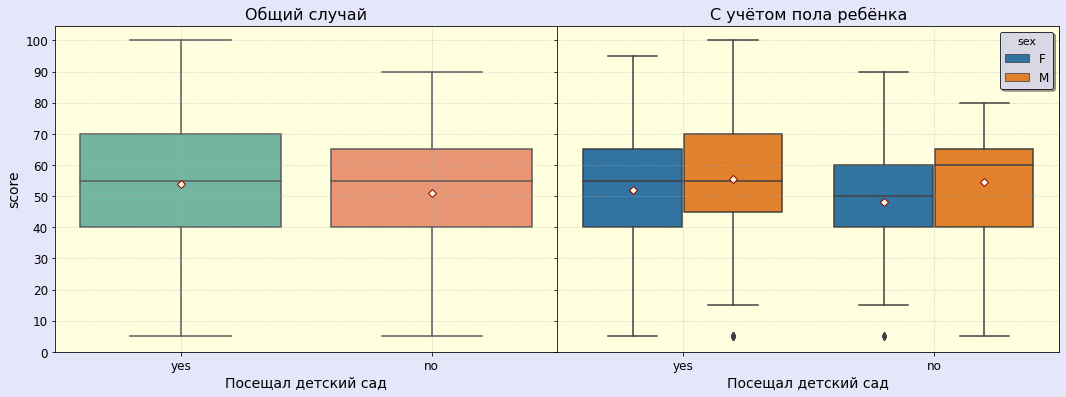

In [63]:
#------------------------------------------------------------------------------#
cols = ["nursery", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.nursery.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 15 пропусков.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="nursery", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="nursery", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="nursery", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Посещал детский сад") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.16. nursery. Промежуточные выводы.
В общем случае, визуально трудно сказать о влиянии на успеваемость.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [64]:
cols = ["nursery", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_yes = df[df.nursery == "yes"].score
df_no = df[df.nursery == "no"].score
print('Feature "nursery": One-Way ANOVA p-value =',
      f_oneway(df_yes, df_no).pvalue.round(3))
#------------------------------------------------------------------------------#
# С учётом пола:
df_yes_M = df[(df.nursery == "yes")&(df.sex == "M")].score
df_yes_F = df[(df.nursery == "yes")&(df.sex == "F")].score
df_no_M = df[(df.nursery == "no")&(df.sex == "M")].score
df_no_F = df[(df.nursery == "no")&(df.sex == "F")].score
print('Feature "nursery" with "sex": One-Way ANOVA p-value =',
      f_oneway(df_yes_M, df_yes_F, df_no_M, df_no_F).pvalue.round(3))

Feature "nursery": One-Way ANOVA p-value = 0.314
Feature "nursery" with "sex": One-Way ANOVA p-value = 0.179


Таким образом, признак "nursery" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [65]:
features_to_delete.append("nursery")
features_to_delete

['school',
 'famsize',
 'reason',
 'guardian',
 'traveltime',
 'studytime, granular',
 'famsup',
 'nursery']

#### 1.17. higher — хочет получить высшее образование (yes или no).

In [66]:
# Признак "higher" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("higher")

Категории: ['yes' nan 'no']
Пропуски: 20


sex,F,M,All
higher,,,
no,4,15,19
yes,195,155,350
All,199,170,369


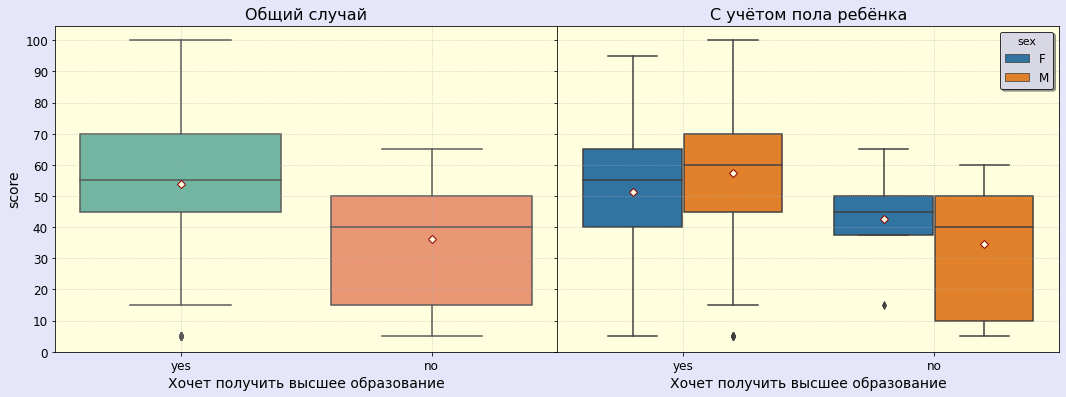

In [67]:
#------------------------------------------------------------------------------#
cols = ["higher", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.higher.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 20 пропусков.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="higher", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="higher", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="higher", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Хочет получить высшее образование") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.17. higher. Промежуточные выводы.
Большинство учеников хочет получить высшее образование - и у них заметно более высокая успеваемость.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [68]:
cols = ["higher", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_yes = df[df.higher == "yes"].score
df_no = df[df.higher == "no"].score
print('Feature "higher": One-Way ANOVA p-value =',
      f_oneway(df_yes, df_no).pvalue.round(3))

Feature "higher": One-Way ANOVA p-value = 0.0


Таким образом, признак "higher" включаем в модель: $p_{value} < \alpha = 0.05$.

#### 1.18. internet — наличие интернета дома (yes или no).

In [69]:
# Признак "internet" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("internet")

Категории: [nan 'yes' 'no']
Пропуски: 34


sex,F,M,All
internet,,,
no,33,22,55
yes,157,143,300
All,190,165,355


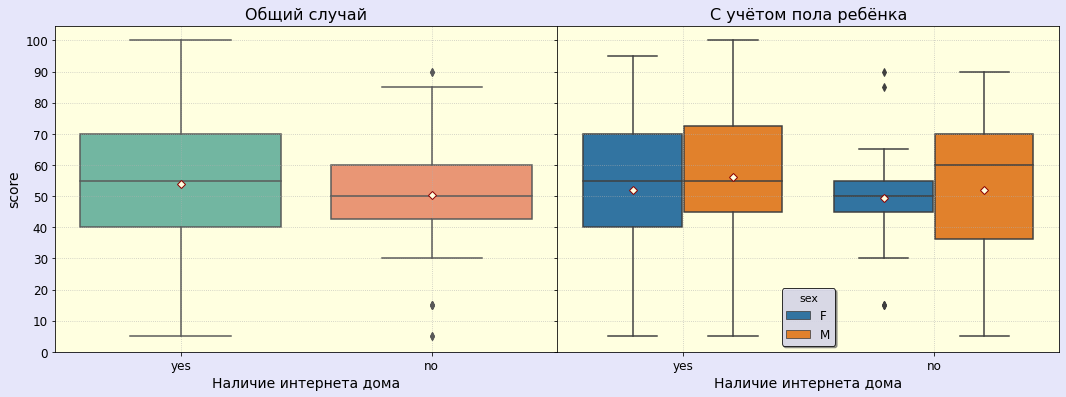

In [70]:
#------------------------------------------------------------------------------#
cols = ["internet", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.internet.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 34 пропуска.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="internet", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="internet", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.boxplot(x="internet", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Наличие интернета дома") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.18. internet. Промежуточные выводы.
Наличие или отсутствие дом интернета слабо влияет на успеваемость.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [71]:
cols = ["internet", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_yes = df[df.internet == "yes"].score
df_no = df[df.internet == "no"].score
print('Feature "internet": One-Way ANOVA p-value =',
      f_oneway(df_yes, df_no).pvalue.round(3))

Feature "internet": One-Way ANOVA p-value = 0.243


Таким образом, признак "internet" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [72]:
features_to_delete.append("internet")
features_to_delete

['school',
 'famsize',
 'reason',
 'guardian',
 'traveltime',
 'studytime, granular',
 'famsup',
 'nursery',
 'internet']

#### 1.19. romantic — в романтических отношениях (yes или no).

In [73]:
# Признак "romantic" является категориальным номинального типа.
# Нечисловой признак.
na_data_nominal.append("romantic")

Категории: ['no' nan 'yes']
Пропуски: 31


sex,F,M,All
romantic,,,
no,114,121,235
yes,77,46,123
All,191,167,358


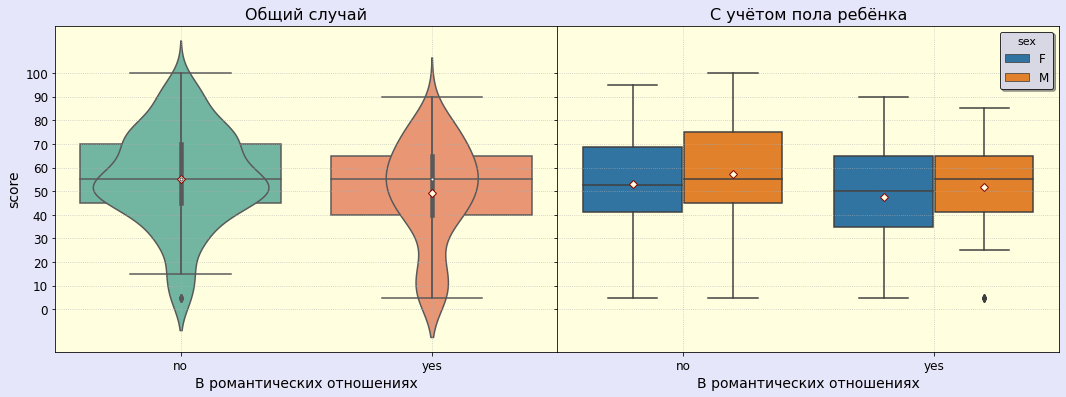

In [74]:
#------------------------------------------------------------------------------#
cols = ["romantic", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.romantic.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Есть 31 пропуск.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="romantic", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="romantic", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.violinplot(x=df.romantic, y=df.score, ax=ax[0], width=0.7, scale="count",
               palette="Set2")
sns.boxplot(x="romantic", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("В романтических отношениях") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.19. romantic. Промежуточные выводы.
Наблюдается тенденция к снижению успеваемости у романтически настроенных учеников.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [75]:
cols = ["romantic", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_yes = df[df.romantic == "yes"].score
df_no = df[df.romantic == "no"].score
print('Feature "romantic": One-Way ANOVA p-value =',
      f_oneway(df_yes, df_no).pvalue.round(3))

Feature "romantic": One-Way ANOVA p-value = 0.009


Таким образом, признак "romantic" включаем в модель: $p_{value} < \alpha = 0.05$.

#### 1.20. famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо).

Категории: [ 4.  5.  3. nan -1.  2.  1.]
Категории: [ 4.  5.  3. nan  1.  2.]
Пропуски: 27


sex,F,M,All
famrel,,,
1.0,5,3,8
2.0,9,8,17
3.0,34,28,62
4.0,97,81,178
5.0,47,50,97
All,192,170,362


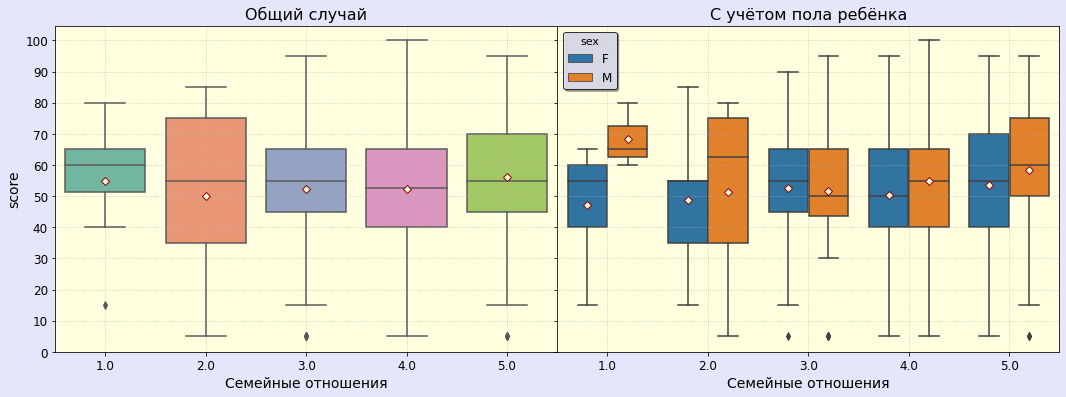

In [76]:
# По сути, famrel - признак ординального типа, но категории этого признака
# уже преобразованы в числа.
#------------------------------------------------------------------------------#
cols = ["famrel", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.famrel.unique())
# Число -1 является выбросом, заменим на 1:
df.famrel = df.famrel.replace(-1, 1)
print("Категории:", df.famrel.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Пропуски: 27.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="famrel", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="famrel", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
##sns.violinplot(x=df.famrel, y=df.score, ax=ax[0], width=0.7, scale="count",
##               palette="Set2")
sns.boxplot(x="famrel", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Семейные отношения") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.20. famrel. Промежуточные выводы.
В общем случае, успеваемость слабо зависит от отношений в семье.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [77]:
cols = ["famrel", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_1 = df[df.famrel == 1].score
df_2 = df[df.famrel == 2].score
df_3 = df[df.famrel == 3].score
df_4 = df[df.famrel == 4].score
df_5 = df[df.famrel == 5].score
print('Feature "famrel": One-Way ANOVA p-value =',
      f_oneway(df_1, df_2, df_3, df_4, df_5).pvalue.round(3))

Feature "famrel": One-Way ANOVA p-value = 0.605


Таким образом, признак "famrel" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [78]:
features_to_delete.append("famrel")
features_to_delete

['school',
 'famsize',
 'reason',
 'guardian',
 'traveltime',
 'studytime, granular',
 'famsup',
 'nursery',
 'internet',
 'famrel']

#### 1.21. freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого).

Категории: [ 3.  2.  4.  1.  5. nan]
Пропуски: 9


sex,F,M,All
freetime,,,
1.0,14,4,18
2.0,37,26,63
3.0,89,63,152
4.0,50,60,110
5.0,8,29,37
All,198,182,380


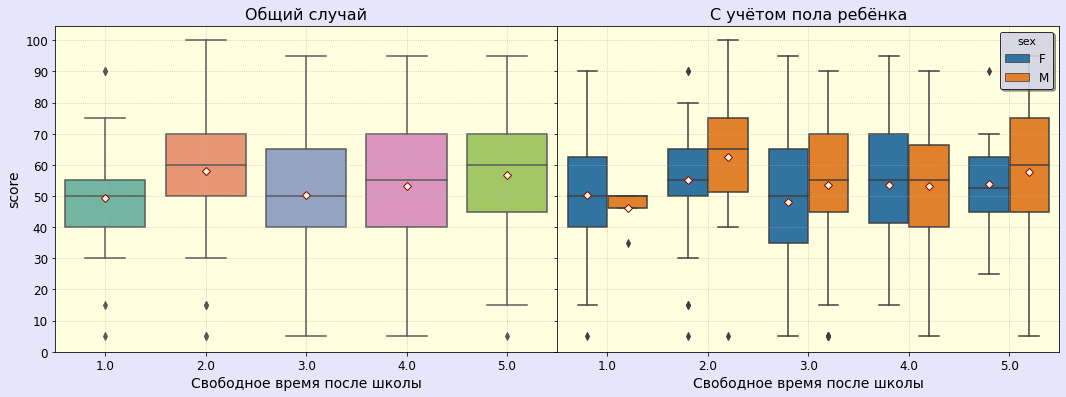

In [79]:
# По сути, freetime - признак ординального типа, но категории этого признака
# уже преобразованы в числа.
#------------------------------------------------------------------------------#
cols = ["freetime", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.freetime.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Пропуски: 9.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="freetime", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="freetime", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
##sns.violinplot(x=df.famrel, y=df.score, ax=ax[0], width=0.7, scale="count",
##               palette="Set2")
sns.boxplot(x="freetime", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Свободное время после школы") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax]
ax[1].legend(title="sex");

#### 1.21. freetime. Промежуточные выводы.
В общем случае, есть некоторая тенденция к увеличению успеваемости с улучшением отношений в семье.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [80]:
cols = ["freetime", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_1 = df[df.freetime == 1].score
df_2 = df[df.freetime == 2].score
df_3 = df[df.freetime == 3].score
df_4 = df[df.freetime == 4].score
df_5 = df[df.freetime == 5].score
print('Feature "freetime": One-Way ANOVA p-value =',
      f_oneway(df_1, df_2, df_3, df_4, df_5).pvalue.round(3))

Feature "freetime": One-Way ANOVA p-value = 0.082


Таким образом, признак "freetime" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [81]:
features_to_delete.append("freetime")
features_to_delete

['school',
 'famsize',
 'reason',
 'guardian',
 'traveltime',
 'studytime, granular',
 'famsup',
 'nursery',
 'internet',
 'famrel',
 'freetime']

#### 1.22. goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много).

Категории: [ 4.  3.  2.  1.  5. nan]
Пропуски: 7


sex,F,M,All
goout,,,
1.0,14,9,23
2.0,55,46,101
3.0,68,58,126
4.0,42,39,81
5.0,20,31,51
All,199,183,382


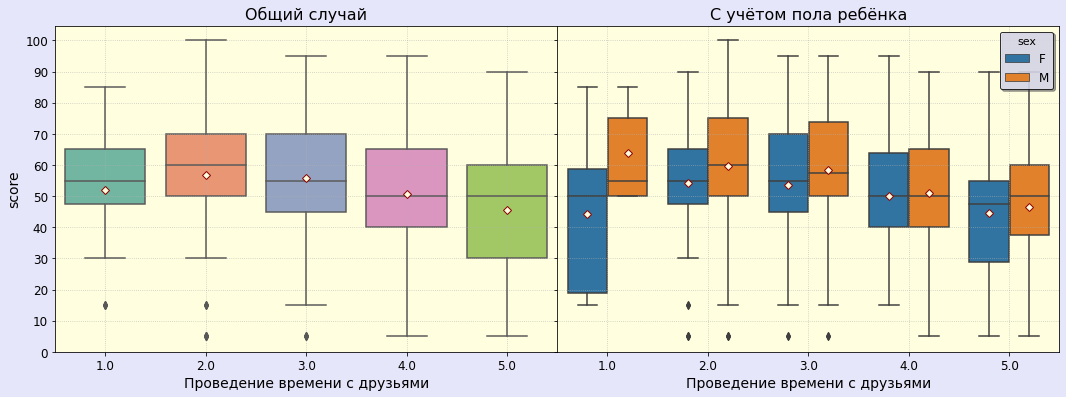

In [82]:
# По сути, goout - признак ординального типа, но категории этого признака
# уже преобразованы в числа.
#------------------------------------------------------------------------------#
cols = ["goout", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.goout.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Пропуски: 7.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="goout", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="goout", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
##sns.violinplot(x=df.famrel, y=df.score, ax=ax[0], width=0.7, scale="count",
##               palette="Set2")
sns.boxplot(x="goout", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Проведение времени с друзьями") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax];
ax[1].legend(title="sex");

#### 1.22. goout. Промежуточные выводы.
Очень чётко проявляется тенденция к снижению успеваемости с увеличением времени, проведённого с друзьями. Впрочем, у девочек (график справа)  
любопытная ситуация - самая низкая успеваемость наблюдается у тех из них, кто менее всего проводит время с друзьями.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [83]:
cols = ["goout", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_1 = df[df.goout == 1].score
df_2 = df[df.goout == 2].score
df_3 = df[df.goout == 3].score
df_4 = df[df.goout == 4].score
df_5 = df[df.goout == 5].score
print('Feature "goout": One-Way ANOVA p-value =',
      f_oneway(df_1, df_2, df_3, df_4, df_5).pvalue.round(3))

Feature "goout": One-Way ANOVA p-value = 0.012


Таким образом, признак "goout" включаем в модель: $p_{value} < \alpha = 0.05$.

#### 1.23. health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо).

Категории: [ 3.  5.  1.  2.  4. nan]
Пропуски: 15


sex,F,M,All
health,,,
1.0,31,16,47
2.0,23,19,42
3.0,51,37,88
4.0,34,26,60
5.0,59,78,137
All,198,176,374


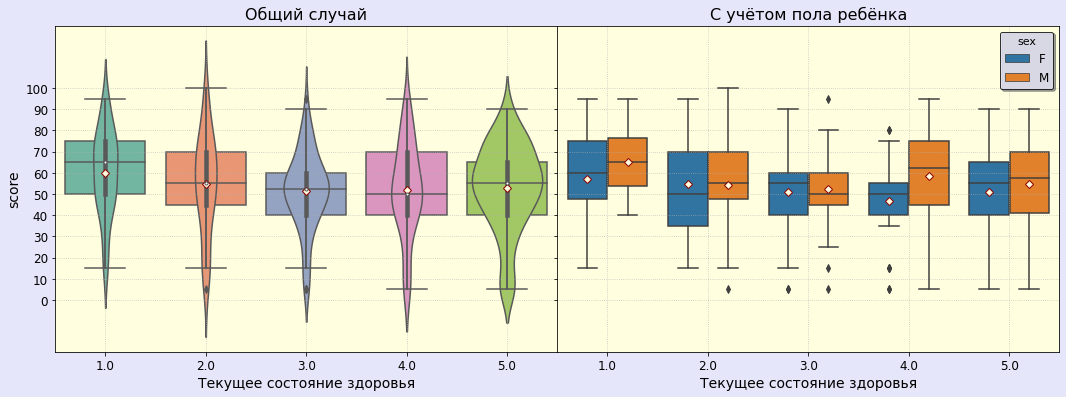

In [84]:
# По сути, health - признак ординального типа, но категории этого признака
# уже преобразованы в числа.
#------------------------------------------------------------------------------#
cols = ["health", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.health.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Пропуски: 15.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
# Посмотрим на частоту категорий и пол:
df_pvt = df.pivot_table(index="health", columns="sex", values="score",
                        aggfunc="count", margins=True)
display(df_pvt)
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.subplots_adjust(wspace=0)
#------------------------------------------------------------------------------#
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(x="health", y="score", data=df, ax=ax[0], showmeans=True,
            meanprops=mean_props, palette="Set2")
sns.violinplot(x=df.health, y=df.score, ax=ax[0], width=0.7, scale="count",
               palette="Set2")
sns.boxplot(x="health", y="score", hue="sex", data=df, ax=ax[1],
            showmeans=True, meanprops=mean_props)
#------------------------------------------------------------------------------#
ax[1].set_ylabel("")
ax[0].set_title("Общий случай"); ax[1].set_title("С учётом пола ребёнка")
[axs.set_xlabel("Текущее состояние здоровья") for axs in ax]
[axs.set_yticks(range(0, 110, 10)) for axs in ax]
[axs.grid("both") for axs in ax];
ax[1].legend(title="sex");

#### 1.23. health. Промежуточные выводы.
Есть определённая тенденция к снижению успеваемости с увеличением состояния здоровья, причём наибольшую успеваемость показывают дети  
с очень плохим состоянием здоровья. У наибольшего количества учеников отличное состояние здоровья.  
Проверим категории признака на статистически значимые различия. $\downarrow$

In [85]:
cols = ["health", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
df_1 = df[df.health == 1].score
df_2 = df[df.health == 2].score
df_3 = df[df.health == 3].score
df_4 = df[df.health == 4].score
df_5 = df[df.health == 5].score
print('Feature "health": One-Way ANOVA p-value =',
      f_oneway(df_1, df_2, df_3, df_4, df_5).pvalue.round(3))

Feature "health": One-Way ANOVA p-value = 0.207


Таким образом, признак "health" _**не**_ включаем в модель: $p_{value} > \alpha = 0.05$.

In [86]:
features_to_delete.append("health")
features_to_delete

['school',
 'famsize',
 'reason',
 'guardian',
 'traveltime',
 'studytime, granular',
 'famsup',
 'nursery',
 'internet',
 'famrel',
 'freetime',
 'health']

#### 1.23. absences — количество пропущенных занятий.

Категории: [  6.   4.  10.   2.   0.  16.  nan  14.   7.   8.  25.  12.  54.  18.
  26.  20.  56.  24.  28.   5.  13.  15.  22.   3. 385.  21.   1.  75.
  30.  19.   9.  11.  38.  40.  23.  17. 212.]
Пропуски: 11


,absences,score
absences,1.000,0.057
score,0.057,1.000


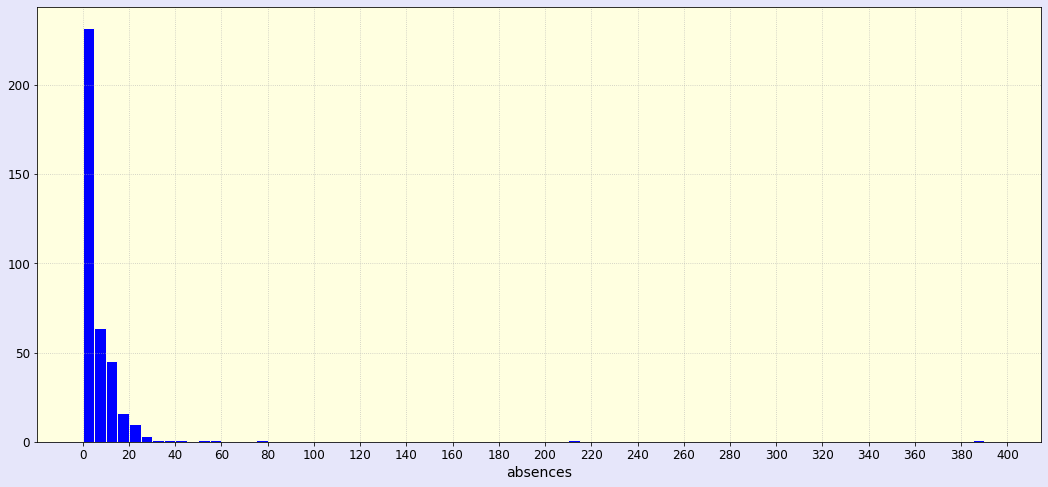

In [87]:
#------------------------------------------------------------------------------#
# Числовой столбец.
cols = ["absences", "score", "sex"]; df = data2[cols].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
print("Категории:", df.absences.unique())
print('Пропуски:', df.isna().sum().iloc[0])
# Пропуски: 11.
# Удалим их пока из рабочего (но не из исходного!) датасета.
df = df.dropna(subset=cols, axis="index")
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(figsize=(18, 8)); ax.set_xticks(range(0, 420, 20))
#------------------------------------------------------------------------------#
h1 = {'color': 'b', 'alpha': 1, 'ec': 'lightyellow', 'align': 'mid'}
bins = [k for k in range(0, 400, 5)]
sns.distplot(df.absences, hist_kws=h1, kde=False, norm_hist=False, bins=bins);
#------------------------------------------------------------------------------#
df[["absences", "score"]].corr().round(3)

#### 1.23. absences. Промежуточные выводы.
Признак absences показывает слабую корреляцию (0.057) с целевой переменной score. Удалим absences из модели.

In [88]:
features_to_delete.append("absences")
features_to_delete

['school',
 'famsize',
 'reason',
 'guardian',
 'traveltime',
 'studytime, granular',
 'famsup',
 'nursery',
 'internet',
 'famrel',
 'freetime',
 'health',
 'absences']

### 2. Обработка пропусков, преобразование признаков.

#### 2.1. Формируем базу данных для модели, удалив несущественные признаки.

In [89]:
stud_for_model = data2.drop(columns=features_to_delete)
stud_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         389 non-null    object 
 1   age         389 non-null    int64  
 2   address     374 non-null    object 
 3   Pstatus     344 non-null    object 
 4   Medu        386 non-null    float64
 5   Fedu        365 non-null    float64
 6   Mjob        370 non-null    object 
 7   Fjob        353 non-null    object 
 8   studytime   382 non-null    float64
 9   failures    367 non-null    float64
 10  schoolsup   380 non-null    object 
 11  paid        350 non-null    object 
 12  activities  375 non-null    object 
 13  higher      369 non-null    object 
 14  romantic    358 non-null    object 
 15  goout       382 non-null    float64
 16  score       389 non-null    float64
dtypes: float64(6), int64(1), object(10)
memory usage: 54.7+ KB


In [90]:
for itm in features_to_delete:
    if itm in na_data_nominal:
        na_data_nominal.remove(itm)
    if itm in na_data_ordinal:
        na_data_ordinal.remove(itm)
na_data_nominal, na_data_ordinal

(['sex',
  'address',
  'Pstatus',
  'Mjob',
  'Fjob',
  'schoolsup',
  'paid',
  'activities',
  'higher',
  'romantic'],
 [])

#### Таким образом, все 10 нечисловых признаков являются категориальными признаками номинального типа.

In [91]:
stud_for_model.isnull().sum()

sex            0
age            0
address       15
Pstatus       45
Medu           3
Fedu          24
Mjob          19
Fjob          36
studytime      7
failures      22
schoolsup      9
paid          39
activities    14
higher        20
romantic      31
goout          7
score          0
dtype: int64

In [92]:
for cols in stud_for_model.columns:
    print(cols, ':', stud_for_model[cols].unique()[:10])

sex : ['F' 'M']
age : [18 17 15 16 19 22 20 21]
address : ['U' nan 'R']
Pstatus : ['A' nan 'T']
Medu : [ 4.  1.  3.  2. nan  0.]
Fedu : [ 4.  1.  2.  3. 40. nan  0.]
Mjob : ['at_home' 'health' 'other' 'services' 'teacher' nan]
Fjob : ['teacher' 'other' nan 'health' 'services' 'at_home']
studytime : [ 2.  3.  1. nan  4.]
failures : [ 0.  3. nan  2.  1.]
schoolsup : ['yes' 'no' nan]
paid : ['no' nan 'yes']
activities : ['no' 'yes' nan]
higher : ['yes' nan 'no']
romantic : ['no' nan 'yes']
goout : [ 4.  3.  2.  1.  5. nan]
score : [30. 50. 75. 55. 95. 45. 60. 70. 80. 25.]


In [93]:
stud_for_model.Fedu = stud_for_model.Fedu.replace(40, 4)
stud_for_model = dist_0(stud_for_model) # Преобразуем "нулевые" выбросы.

#### 2.2. Заполнение пропусков данных.
Итак, есть 14 признаков, в которых присутствуют пропуски.

##### 2.2.1. Признаки "Fedu" и "Medu".

In [94]:
#------------------------------------------------------------------------------#
cols = ["Fedu", "Medu"]; df = stud_for_model[cols].copy()
display(df.Fedu.unique())
# Заменим пока пропуски на "unknown":
df["Medu"] = df["Medu"].replace(np.nan, "unknown")
df["Fedu"] = df["Fedu"].replace(np.nan, "unknown")
# Сравним расположение неизвестных значений в обоих признаках:
df[(df.Medu == "unknown")|(df.Fedu == "unknown")][["Medu", "Fedu"]]
# Итак, неизвестные значения не перекрываются.

array([ 4.,  1.,  2.,  3., nan,  0.])

,Medu,Fedu
21,4,unknown
42,4,unknown
46,3,unknown
57,4,unknown
58,1,unknown
67,3,unknown
92,unknown,1
137,3,unknown
142,4,unknown
159,3,unknown


$\;\;\;$Для признаков "Fedu" и "Medu" пропуски не перекрывают друг друга. Это даёт возможность предсказать пропущенный уровень образования 
отца на основе уровня образования матери, и наоборот. Сделаем это, базируясь на _байесовском_ подходе.  
$\;\;\;$Через $F_{i}$ обозначим событие "у отца образование $i$-го уровня" в наугад взятой семье, а через $M_{j}$ - "у матери образование $j$-го 
уровня" в наугад взятой семье, $i,\,j = 0, 1, ..., n$. Нет причин полагать, что события $F_{i}$ и $M_{j}$ являются независимыми, следовательно, 
вероятность произведения этих событий определяется по известному выражению:  
$P(F_{i} M_{j}) = P(F_{i})\,P(M_{j}|F_{i}) = P(M_{j})\,P(F_{i}|M_{j})$,  
где $P(M_{j}|F_{i})$ и $P(F_{i}|M_{j})$ - условные вероятности первого (в скобках) события в результате реализации второго события.  
$\;\;\;$Для заполнения пропуска данных в столбце "Fedu" мы должны выдвинуть гипотезы и выяснить, какая из них является наиболее правдоподобной. Всего имеется по пять уровней образования у отца и у матери, т.е. имеем пять гипотез $F_{0}$, $F_{1}$, $F_{2}$, $F_{3}$, $F_{4}$. Соответствующие вероятности $P(F_{i})$ называются априорными вероятностями выдвинутых гипотез:  
$P(F_{i}) = n(F_{i})\;/\;n_{tot}$,  
где $n(F_{i})$ - количество семей, благоприятствующих событию $F_{i}$, а $n_{tot}$ - общее количество семей.  
$\;\;\;$Конечно, можно ограничиться этими вероятностями, выбрать наибольшую среди них и заполнить пропуски соответствующим значением. Иногда так и делают, когда нет других вариантов, - заполняют пропуски модой, наболее частым значением признака. Однако у нас другой вариант есть - использовать в качестве уточняющей информации события $M_{j}$, $j = 0, 1, ..., 4$. Из приведенной выше формулы для вероятности произведения событий следуют формулы Байеса (в укороченной форме) для _апостериорной_ вероятности выдвинутых ранее гипотез:  
$P(F_{i}|M_{j}) = P(F_{i})\,P(M_{j}|F_{i})\;/\;P(M_{j})$.  
$\;\;\;$Одна из популярных интерпретаций этой формулы гласит, что априорную вероятность гипотезы $F_{i}$ можно уточнить на основе того факта, что появилось событие $M_{j}$, т.е. условная (апостериорная) вероятность гипотезы $F_{i}$ может заметно отличаться (как в б$\acute о$льшую, так и в меньшую стороны) от её априорной вероятности. При этом событие $M_{j}$ не является произвольным - оно связано с исходными гипотезами. В терминах "байесианистов" событие $M_{j}$ именуется "экспериментом", поставленным для подтверждения или опровержения исходных событий-гипотез $F_{i}$.  
$\;\;\;$Можно ограничиться формулами Байеса, вычислить условные вероятности гипотез $P(F_{i}|M_{j})$ и, выбрав наибольшую из них, заполнить пропуск данных соответствующим значением $F_{i}$. Однако можно улучшить отбор наиболее правдоподобной гипотезы, введя коэффициенты правдоподобия $l_{ij}$, которые являются элементами матрицы $L$ правдоподобия:  
  
$l_{ij} = \frac{P(F_{i}|M_{j})}{P(F_{i})} = \frac{P(M_{j}|F_{i})}{P(M_{j})} = \frac{P(F_{i} M_{j})}{P(F_{i})\;P(M_{j})}$  

Смысл этих коэффициентов: если $l_{ij} = \frac{P(F_{i}|M_{j})}{P(F_{i})} > 1$, это значит, что событие-"эксперимент" $M_{j}$ подтверждает гипотезу $F_{i}$, т.е. апостериорная вероятность $P(F_{i}|M_{j})$ становится больше априорной вероятности $P(F_{i})$ после того, как происходит событие $M_{j}$. Если условие $l_{ij} = \frac{P(F_{i}|M_{j})}{P(F_{i})} > 1$ выполняется для нескольких гипотез $F_{i}$, то выбирается та из них, для которой коэффициент правдоподобия имеет наибольшую величину.  
$\;\;\;$В заключение отметим, что предложенный способ с коэффициентами правдоподобия работает "в обе стороны" - его можно использовать для заполнения пропусков данных как в признаке "Fedu", так и в признаке "Medu". В последнем случае событиями-гипотезами будут $M_{j}$, а "экспериментальным" подтверждением наиболее правдоподобной гипотезы - факт появления события $F_{i}$. Вычисление коэффициентов правдоподобия проведём по следующей формуле:  
$l_{ij} = \frac{P(F_{i} M_{j})}{P(F_{i})\;P(M_{j})}$.

In [95]:
#------------------------------------------------------------------------------#
cols = ["Fedu", "Medu", "score"]; df = stud_for_model[cols].copy()
# Удалим пока пропуски из рабочего датафрема (но не из исходного!).
df = df.dropna(subset=["Fedu", "Medu"], axis = "index")
#------------------------------------------------------------------------------#
# Частотная матрица для априорных вероятностей событий Fi и Mj:
df1 = pd.DataFrame(df.Fedu.value_counts()).sort_index()
df2 = pd.DataFrame(df.Medu.value_counts()).sort_index()
df_PFi_PMj = df1.join(df2)
print("Частотная матрица для априорных вероятностей событий Fi и Mj:")
display(df_PFi_PMj)
#------------------------------------------------------------------------------#
# Частотная матрица для вероятности произведения P(Fi*Mj):
df_PFiMj = df.pivot_table(index="Fedu", columns="Medu", values="score",
                       aggfunc="count", fill_value="0")
print("\nЧастотная матрица для вероятности произведения P(Fi*Mj):")
display(df_PFiMj)
#------------------------------------------------------------------------------#
df_L = df_PFiMj.copy()
# Матрица правдоподобия.
# 1. Матрицу P(Fi*Mj) делим на P(Mj):
n_tot = df.shape[0]
print(f"Количество рассматриваемых семей: {n_tot}.")
for col in df_L.columns:
    for idx in df_L.index:
        df_ij = df_L.loc[idx, col]
        df_Mj = df_PFi_PMj.loc[col, "Medu"]
        df_L.loc[idx, col] = float(df_ij) / float(df_Mj)
# 2. Делим на P(Fi) и получаем матрицу правдоподобия:
# Матрица коэффициентов правдоподобия: l(i, j) = P(Fi|Mj) / P(Fi)
print("\n\nМатрица коэффициентов правдоподобия:\nl(i, j) = P(Fi|Mj)/P(Fi) = P(Mj|Fi)/P(Mj)")
for col in df_L.columns:
    for idx in df_L.index:
        df_ij = df_L.loc[idx, col]
        df_Fi = df_PFi_PMj.loc[idx, "Fedu"] / n_tot
        df_L.loc[idx, col] = round(float(df_ij) / float(df_Fi), 3)
display(df_L)

Частотная матрица для априорных вероятностей событий Fi и Mj:


,Fedu,Medu
0.0,2,3
1.0,74,53
2.0,104,96
3.0,93,89
4.0,89,121



Частотная матрица для вероятности произведения P(Fi*Mj):


Medu,0.0,1.0,2.0,3.0,4.0
Fedu,,,,,
0.0,0,1.0,0,0,1
1.0,1,34.0,26,13,0
2.0,2,12.0,47,25,18
3.0,0,5.0,16,33,39
4.0,0,1.0,7,18,63


Количество рассматриваемых семей: 362.


Матрица коэффициентов правдоподобия:
l(i, j) = P(Fi|Mj)/P(Fi) = P(Mj|Fi)/P(Mj)


Medu,0.0,1.0,2.0,3.0,4.0
Fedu,,,,,
0.0,0,3.415,0,0,1.496
1.0,1.631,3.138,1.325,0.715,0
2.0,2.321,0.788,1.704,0.978,0.518
3.0,0,0.367,0.649,1.443,1.255
4.0,0,0.077,0.297,0.823,2.118


$\;\;\;$В целом, можно сказать, что статистика подтверждает народную мудрость - "подобное тянется к подобному". Для высоких уровней образования (3-ий и 4-ый) наболее правдоподобной оказывается гипотеза о том, что образование обоих родителей имеет одинаковый уровень. Лишь на низких уровнях образования (0-ой и 1-ый) наблюдаются отклонения от этой гипотезы, но эти случаи редки - так, например, из 362-ух рассмотренных семей имеют место лишь 2 случая семей, где мать не имеет ообразования, и 3 случая, когда образование отсутствует у отца.  
$\;\;\;$Используем матрицу правдоподобия и заполним пропуски данных для признаков "Fedu" и "Medu".

In [96]:
#------------------------------------------------------------------------------#
cols = ["Fedu", "Medu"]; 
# Заменим пропуски на "unknown":
stud_for_model["Medu"] = stud_for_model["Medu"].replace(np.nan, "unknown")
stud_for_model["Fedu"] = stud_for_model["Fedu"].replace(np.nan, "unknown")
df_for_check = stud_for_model[cols].copy()
l_Fi = pd.DataFrame([2, 0, 2, 3, 4], columns=["Fedu predicted"])
l_Mj = pd.DataFrame([1, 1, 0, 3, 4], columns=["Medu predicted"])
edu_predicted = l_Fi.join(l_Mj)
display(edu_predicted)
# Предсказание уровня образования - для пап:
idx_F = stud_for_model[stud_for_model["Fedu"] == "unknown"].index
for idx in idx_F:
    m_edu = stud_for_model.loc[idx, "Medu"]
    stud_for_model.loc[idx, "Fedu"] = edu_predicted.loc[m_edu, "Fedu predicted"]
# Предсказание уровня образования - для мам:
idx_M = stud_for_model[stud_for_model["Medu"] == "unknown"].index
for idx in idx_M:
    f_edu = stud_for_model.loc[idx, "Fedu"]
    stud_for_model.loc[idx, "Medu"] = edu_predicted.loc[f_edu, "Medu predicted"]
#------------------------------------------------------------------------------#
# Проверка для пап:
display(df_for_check.loc[idx_F][["Medu", "Fedu"]].join(
stud_for_model.loc[idx_F][["Fedu"]], lsuffix="_check"))
# Проверка для мам:
display(df_for_check.loc[idx_M][["Fedu", "Medu"]].join(
stud_for_model.loc[idx_M][["Medu"]], lsuffix="_check"))
#------------------------------------------------------------------------------#
stud_for_model.isnull().sum()

,Fedu predicted,Medu predicted
0,2,1
1,0,1
2,2,0
3,3,3
4,4,4


,Medu,Fedu_check,Fedu
21,4,unknown,4
42,4,unknown,4
46,3,unknown,3
57,4,unknown,4
58,1,unknown,0
67,3,unknown,3
137,3,unknown,3
142,4,unknown,4
159,3,unknown,3
161,3,unknown,3


,Fedu,Medu_check,Medu
92,1,unknown,1
193,3,unknown,3
239,2,unknown,0


sex            0
age            0
address       15
Pstatus       45
Medu           0
Fedu           0
Mjob          19
Fjob          36
studytime      7
failures      22
schoolsup      9
paid          39
activities    14
higher        20
romantic      31
goout          7
score          0
dtype: int64

Таким образом можно заполнить пропуски и в других "парных" (т.е. логически связанных) признаках, например, для признаков: "Mjob" и "Fjob", "goout" и "freetime"... Однако я уже не имею времени для осуществления этого data mining, поэтому просто заполню пропуски модой, т.е. наиболее часто встречающейся величиной признака.

##### 2.2.2. Заполнение пропусков в оставшихся признаках наиболее часто встречающимся значением.

In [97]:
#------------------------------------------------------------------------------#
for cols in stud_for_model.columns:
    mode_val = stud_for_model[cols].value_counts().index[0]
    stud_for_model[cols] = stud_for_model[cols].replace(np.nan, mode_val)
display(stud_for_model.isnull().sum())
stud_for_model.info()

sex           0
age           0
address       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
studytime     0
failures      0
schoolsup     0
paid          0
activities    0
higher        0
romantic      0
goout         0
score         0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         389 non-null    object 
 1   age         389 non-null    int64  
 2   address     389 non-null    object 
 3   Pstatus     389 non-null    object 
 4   Medu        389 non-null    float64
 5   Fedu        389 non-null    float64
 6   Mjob        389 non-null    object 
 7   Fjob        389 non-null    object 
 8   studytime   389 non-null    float64
 9   failures    389 non-null    float64
 10  schoolsup   389 non-null    object 
 11  paid        389 non-null    object 
 12  activities  389 non-null    object 
 13  higher      389 non-null    object 
 14  romantic    389 non-null    object 
 15  goout       389 non-null    float64
 16  score       389 non-null    float64
dtypes: float64(6), int64(1), object(10)
memory usage: 64.7+ KB


#### 2.3. Преобразование категориальных признаков номинального типа в числовые признаки.

In [98]:
#------------------------------------------------------------------------------#
from sklearn.preprocessing import LabelEncoder
labencoder = LabelEncoder()
for col in stud_for_model.columns:
    if stud_for_model[col].dtypes == "object":
        stud_for_model[col] = labencoder.fit_transform(stud_for_model[col])

display(stud_for_model.sample(10))
stud_for_model.info()

,sex,age,address,Pstatus,Medu,Fedu,Mjob,Fjob,studytime,failures,schoolsup,paid,activities,higher,romantic,goout,score
257,1,19,1,0,4.0,3.0,3,0,2.0,0.0,0,0,0,1,0,1.0,55.0
228,1,18,1,1,2.0,1.0,0,2,2.0,0.0,1,1,1,1,1,2.0,45.0
38,0,15,0,1,3.0,4.0,3,1,3.0,0.0,1,1,1,1,0,2.0,55.0
127,0,19,1,1,0.0,1.0,0,2,2.0,3.0,0,0,0,0,0,2.0,45.0
85,0,15,1,1,4.0,4.0,3,3,2.0,2.0,0,1,0,1,1,4.0,40.0
325,1,18,1,1,4.0,4.0,2,2,3.0,0.0,0,0,1,1,0,3.0,55.0
361,1,18,0,1,1.0,1.0,0,2,2.0,1.0,0,0,1,0,0,3.0,60.0
65,0,16,1,1,4.0,3.0,4,3,2.0,0.0,0,0,1,1,0,3.0,75.0
393,1,18,0,1,3.0,2.0,3,2,1.0,0.0,0,0,1,1,0,1.0,50.0
198,0,17,1,1,4.0,4.0,3,4,1.0,1.0,0,0,0,1,0,4.0,90.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         389 non-null    int32  
 1   age         389 non-null    int64  
 2   address     389 non-null    int32  
 3   Pstatus     389 non-null    int32  
 4   Medu        389 non-null    float64
 5   Fedu        389 non-null    float64
 6   Mjob        389 non-null    int32  
 7   Fjob        389 non-null    int32  
 8   studytime   389 non-null    float64
 9   failures    389 non-null    float64
 10  schoolsup   389 non-null    int32  
 11  paid        389 non-null    int32  
 12  activities  389 non-null    int32  
 13  higher      389 non-null    int32  
 14  romantic    389 non-null    int32  
 15  goout       389 non-null    float64
 16  score       389 non-null    float64
dtypes: float64(6), int32(10), int64(1)
memory usage: 49.5 KB


#### 2.4. Нормализация целевого признака "score".
Признак "score" меняется от 0 до 100. Остальные признаки, отобранные для модели, имеют максимум 5 и миниум 0. Снизим порядок величины score, просто поделив на 10.

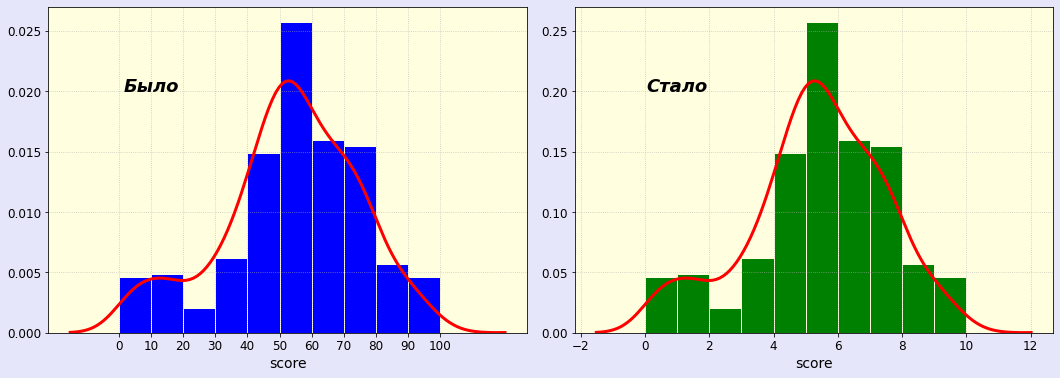

In [99]:
#------------------------------------------------------------------------------#
df = data2[["score"]].copy()
df = dist_0(df) # Преобразуем "нулевые" выбросы.
mean_val = stud_for_model.score.mean()
std_val = stud_for_model.score.std()
stud_for_model.loc[:, "score"] = stud_for_model.score / 10
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].set_xticks(range(0, 110, 10)); fig.subplots_adjust(wspace=0.1)
#------------------------------------------------------------------------------#
h1 = {'color': 'b', 'ec': 'lightyellow', 'alpha': 1, 'align': 'mid'}
k1 = {'color': 'r', 'lw': 3}
bins_0 = [k for k in range(0, 110, 10)]
sns.distplot(df.score, hist_kws=h1, kde_kws=k1, bins=bins_0, ax=ax[0])
#------------------------------------------------------------------------------#
h2 = {'color': 'g', 'ec': 'lightyellow', 'alpha': 1, 'align': 'mid'}
k2 = {'color': 'r', 'lw': 3}
bins_1 = [k for k in range(0, 11)]
sns.distplot(stud_for_model.score, hist_kws=h2, kde_kws=k2, bins=bins_1, ax=ax[1])
#------------------------------------------------------------------------------#
ax[0].text(10, 0.02, "Было", fontsize=18, style="italic", weight="bold",
           ha="center")
ax[1].text(1, 0.2, "Стало", fontsize=18, style="italic", weight="bold",
          ha="center");

### 3. Выводы.
$\;\;\;$Таким образом, в рамках проекта был провён разведывательный анализ данных, в ходе которого проанализированы признаки, входящие в исходную базу данных. Целевой признак - "score", оценка за госэкзамен по математике.  
$\;\;\;$В результате анализа были отобраны 17 признаков из начальных 30. На основе байесовского подхода заполнены пропуски в некоторых признаках. За недостатком времени пропуски в остальных признаках были заполнены наиболее частыми значениями признака.  
$\;\;\;$Категориальные нечисловые признаки были преобразованы в числовые - с помощью объекта класса LabelEncoder(). Целевая переменная "score" подверглась масштабированию для уменьшения её величин на порядок.